Group: Grog

Team members:


*   Bianchi Lorenzo
*   Pezzano Mattia
*   Shoala Mohamed
*   Tirabassi Maurizio

Dataset: BeerQA

Task: Question answering from Wikipedia

# Introduction

Welcome to our Colab Notebook, where we present the development of a sophisticated chatbot designed to handle multi-hop open domain questions. Our task was to create a system capable of leveraging Wikipedia pages as references to provide accurate and informative answers. This chatbot is based on the BeerQA dataset, which serves as the foundation for training and evaluating our model.

The main challenge in this project was to ensure that the chatbot can navigate through multiple pieces of information across different Wikipedia articles to construct coherent and correct responses.

In this notebook, we will walk you through the steps involved in building this chatbot, we hope you find our work both informative and inspiring as you explore the intricate world of multi-hop question answering.

In [ ]:
# Colab
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
data_path = '/content/drive/MyDrive/proj-nlp-2024/data'
os.chdir(data_path)

# # Local
# os.chdir('c:\\Users\\green\\Documents\\GitHub\\proj-nlp-2024\\data')

Mounted at /content/drive


In [ ]:
!pip install -U sentence-transformers
!pip install hnswlib
!pip -q install sentencepiece
!pip install accelerate
!pip install --upgrade transformers accelerate torch
!pip install -q -U transformers bitsandbytes accelerate xformers
!pip install -q python-terrier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import os
import json
from pandas.core.common import flatten
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch
import hnswlib
import pickle
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, GPT2Tokenizer, GPT2LMHeadModel, AutoModelForCausalLM, AutoTokenizer, pipeline
import accelerate
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from collections import Counter
import re

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluation Datasets

## Dataframe Creation

In [ ]:
# Loading the json file
train_path = os.path.join(os.getcwd(), 'beerqa_train_v1.0.json')
with open(train_path, 'r') as file:
    train_dataset = json.load(file)

Preparing the dataframe

In [ ]:
dataset = pd.DataFrame(train_dataset['data'])
dataset = dataset.drop(columns=['id', 'context'])
dataset.head()

src                      answers  \
0     squad                       [1793]   
1     squad    [Investiture Controversy]   
2     squad  [the Thermidorian Reaction]   
3     squad                    [Morales]   
4  hotpotqa        [Darren Lynn Bousman]   

                                            question  
0        When did Wordsworth initially attack Burke?  
1  The clash between Henry IV and the pope was pa...  
2  What historical event brought about the fall o...  
3  Who came up with a policy for indigenous auton...  
4  Greg Hoffman was working on "Saw III," a 2006 ...

In [ ]:
dataset.shape

(134043, 3)

We create two distinct dataframes based on their original datasets, SQuAD and HotpotQA, because these datasets are designed to evaluate different question-answering tasks: SQuAD for single-hop questions and HotpotQA for multi-hop questions.

In [ ]:
dataset['src'].value_counts()

src
hotpotqa    74758
squad       59285
Name: count, dtype: int64

We are slicing the dataset to a smaller size because working with 130,000 rows would be too time-consuming.

In [ ]:
n = 500
seed = 420

# Group the dataset by 'src' column
grouped = dataset.groupby('src')

# Process the hotpotqa group
df_hotpotqa = (
    grouped.get_group('hotpotqa')
    .drop(columns=['src'])
    .sample(n=n, random_state=seed)
    .astype(str)
)
df_hotpotqa['answers'] = df_hotpotqa['answers'].str.replace(r"[\"'\[\]]", "", regex=True)

# Process the squad group
df_squad = (
    grouped.get_group('squad')
    .drop(columns=['src'])
    .sample(n=n, random_state=seed)
    .astype(str)
)
df_squad['answers'] = df_squad['answers'].str.replace(r"[\"'\[\]]", "", regex=True)

In [ ]:
df_hotpotqa.head()

answers                                           question
118289          yes  Are The Delineator and Moondance both types of...
58750        Boogie  The Nike Global Challenge has featured players...
7973     Lee Marvin  The Dirty Dozen: Next Mission is a made-for-TV...
117414     Mystique  What is the name of the role played by Rebecca...
130704  Bryan Adams  Who co-wrote the song "Let's Make a Night to R...

In [ ]:
df_squad.head()

answers  \
7922         doctoral degree   
53126      Federalist No. 43   
36763   the British monarchy   
101617          state courts   
57795               Canadian   

                                                 question  
7922    What sort of credentials did Franklin S. Harri...  
53126   Where are these ideas located in the Federalis...  
36763                   Who is Buckingham palace home to?  
101617                    Where are cases usually argued?  
57795                  The band Rush is what nationality?

Defining a function to run predictions on a dataframe using a specific pipeline and append the results to a new column.

In [ ]:
def run_predictions(dataset, path, function):
  if os.path.exists(path):
    return pd.read_csv(path).astype(str)
  else:
    predictions_df = dataset
    predictions_df.loc[:, 'predictions'] = predictions_df['question'].apply(function).astype(str)
    predictions_df.to_csv(path) # Saving the dataframe
    return predictions_df

## Evaluation Functions

In [ ]:
def f1_score(generated_answer, reference_answer):
  # Tokenize the answers (you can use more sophisticated tokenizers if needed)
  generated_tokens = generated_answer.lower().split()
  reference_tokens = reference_answer.lower().split()

  # Count the tokens
  gen_token_counts = Counter(generated_tokens)
  ref_token_counts = Counter(reference_tokens)

  # Calculate True Positives, False Positives, and False Negatives
  TP = sum((gen_token_counts & ref_token_counts).values())
  FP = sum((gen_token_counts - ref_token_counts).values())
  FN = sum((ref_token_counts - gen_token_counts).values())

  # Precision and Recall
  precision = TP / (TP + FP) if (TP + FP) > 0 else 0
  recall = TP / (TP + FN) if (TP + FN) > 0 else 0

  # F1 Score
  if precision + recall > 0:
    f1 = 2 * (precision * recall) / (precision + recall)
  else:
    f1 = 0

  return f1

def EM_score(generated_answer, reference_answer):
  generated_answer = generated_answer.lower()
  reference_answer = reference_answer.lower()
  if generated_answer==reference_answer:
    return 1
  else: return 0

Assuming the dataframe with model predictions includes columns named "predictions" and "answers," we define the following scoring function.

In [ ]:
def score_predictions(data):
  # Add a column to the dataframe
  data['f1 score'] = data.apply(lambda row: f1_score(row['predictions'], row['answers']), axis=1)
  data['EM score'] = data.apply(lambda row: EM_score(row['predictions'], row['answers']), axis=1)
  # Calculate the mean of the two scores
  f1_mean = data['f1 score'].mean()
  em_mean = data['EM score'].mean()
  print(f'F1: {f1_mean}\nEM: {em_mean}')

# Document Corpus

We created the corpus by extracting single passages from the contexts of the training samples, providing us with a sufficiently good initial dataset. Using the preprocessed Wikipedia would have taken too much time.

## Corpus Creation

Seeing what one training data sample looks like

In [ ]:
train_dataset.get('data', {})[22]

{'id': 'cf01284af96aa29b6b8f098273b8f13122447ac0',
 'src': 'hotpotqa',
 'answers': ['the United Kingdom'],
 'question': 'Where is the group founded by Noel Stanton based?',
 'context': [['Jesus Army',
   'The Jesus Army, also known as the Jesus Fellowship Church and the Bugbrooke Community, was a neocharismatic evangelical Christian movement based in the United Kingdom, part of the British New Church Movement. The name "Jesus Army" was specifically used for the outreach and street-based evangelism for which they were known.'],
  ['Noel Stanton',
   'Stanton was born in Bedfordshire in the East of England, and educated at Bedford Modern School. His parents were farmers. When he was 18, he was conscripted into British military service with the Royal Navy. The navy sent him to Sydney, Australia, where he was approached by evangelist Frank Jenner, who asked him, "If you should die tonight, where would you go? Would it be heaven or hell?" Stanton felt convicted for several months afterwards

We created a dummy dataset by compiling paragraphs from the context of each training sample.

In [ ]:
# Creating the corpus out of the json file contexts
data_dict = train_dataset.get('data', {}) # Extracting the data dictionary
context_list = [list(flatten(entry.get('context', ''))) for entry in data_dict] # List of list of strings
context_string = list(flatten(context_list)) # List of strings
corpus = context_string[1::2] # Removing the strings corresponding to titles
corpus = list(dict.fromkeys(corpus)) # Removing duplicates

In [ ]:
len(corpus)

119314

In [ ]:
corpus[:3]

['In the 19th century, Burke was praised by both liberals and conservatives. Burke\'s friend Philip Francis wrote that Burke "was a man who truly & prophetically foresaw all the consequences which would rise from the adoption of the French principles", but because Burke wrote with so much passion, people were doubtful of his arguments. William Windham spoke from the same bench in the House of Commons as Burke had when he had separated from Fox and an observer said Windham spoke "like the ghost of Burke" when he made a speech against peace with France in 1801. William Hazlitt, a political opponent of Burke, regarded him as amongst his three favourite writers (the others being Junius and Rousseau) and made it "a test of the sense and candour of any one belonging to the opposite party, whether he allowed Burke to be a great man". William Wordsworth was originally a supporter of the French Revolution and attacked Burke in "A Letter to the Bishop of Llandaff" (1793), but by the early 19th c

## Exploratory Data Analysis

In [ ]:
unique_corpus=corpus

Cleaninig the corpus

In [ ]:
def clean_text(text):
    # Remove punctuation and non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

In [ ]:
import re
cleaned_corpus = [clean_text(doc) for doc in unique_corpus]

Average document length

In [ ]:
# Calculate the length of each document in words
document_lengths = [len(doc.split()) for doc in cleaned_corpus]

# Compute the average document length
average_document_length = np.mean(document_lengths)

print("Average document length:", average_document_length)

Average document length: 75.4773454917277


Vocabulary Size

In [ ]:
# Calculate the vocabulary size
all_words = [word for doc in cleaned_corpus for word in doc.split()]
unique_words = set(all_words)
vocabulary_size = len(unique_words)
print("Vocabulary size:", vocabulary_size)

Vocabulary size: 248380


Frequency Analysis

In [ ]:
# Frequency analysis with stop words removal
import nltk
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word.lower() not in stop_words]
word_counts = Counter(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
word_counts

Counter({'abraham': 219,
         'bo': 90,
         'weinberg': 32,
         'january': 6261,
         '7': 2769,
         '1900': 336,
         'september': 6570,
         '9': 2587,
         '1935': 530,
         'jewish': 942,
         'new': 19521,
         'york': 7440,
         'city': 14063,
         'mobster': 58,
         'became': 7036,
         'hitman': 55,
         'chief': 1334,
         'lieutenant': 373,
         'prohibitionera': 5,
         'gang': 362,
         'boss': 264,
         'dutch': 1363,
         'schultz': 61,
         'expanded': 615,
         'bootlegging': 8,
         'operations': 991,
         'manhattan': 710,
         'prohibition': 79,
         'recruited': 170,
         'abe': 42,
         'brother': 1768,
         'george': 2980,
         'would': 4298,
         'become': 2159,
         'one': 19019,
         'schultzs': 2,
         'top': 3463,
         'gunmen': 8,
         'bootleg': 33,
         'wars': 787,
         'later': 7307,
         

In [ ]:
most_common_words = word_counts.most_common(20)
print("Most common words:", most_common_words)

Most common words: [('film', 30172), ('american', 29425), ('also', 25870), ('first', 23734), ('born', 21447), ('known', 20602), ('new', 19521), ('one', 19019), ('united', 16545), ('states', 15290), ('series', 14438), ('city', 14063), ('album', 13985), ('released', 12906), ('two', 12095), ('world', 11712), ('best', 10340), ('music', 10299), ('university', 9895), ('national', 9752)]


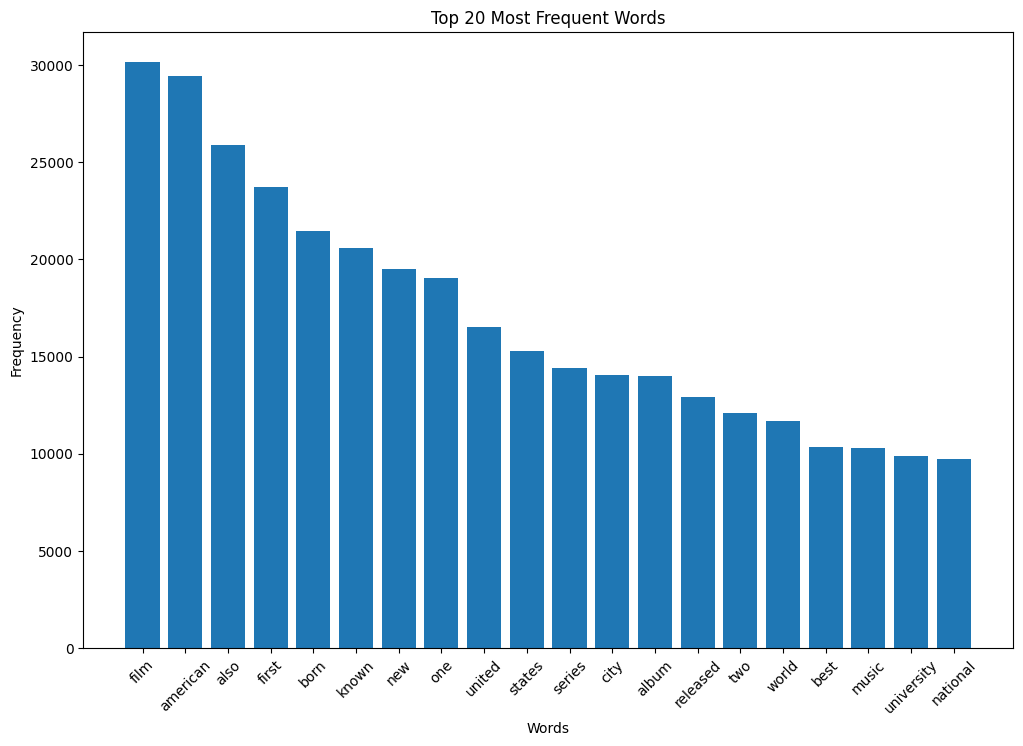

In [ ]:
import matplotlib.pyplot as plt

words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 8))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

Most Common Bigrams

In [ ]:
def get_bigrams(texts):
    bigram_list = []
    for text in texts:
        tokens = [word for word in text.split() if word not in stop_words]
        bigrams = list(ngrams(tokens, 2))
        bigram_list.extend(bigrams)
    return bigram_list

In [ ]:
from nltk.util import ngrams

bigrams = get_bigrams(cleaned_corpus)


In [ ]:
bigram_counts = Counter(bigrams)


Most common bigrams: [(('united', 'states'), 12936), (('new', 'york'), 7087), (('best', 'known'), 4555), (('film', 'directed'), 3852), (('also', 'known'), 3587), (('studio', 'album'), 3106), (('television', 'series'), 2869), (('rock', 'band'), 2694), (('world', 'war'), 2461), (('york', 'city'), 2149), (('united', 'kingdom'), 1952), (('high', 'school'), 1951), (('los', 'angeles'), 1887), (('award', 'best'), 1771), (('football', 'league'), 1698), (('comedy', 'film'), 1439), (('war', 'ii'), 1400), (('drama', 'film'), 1398), (('film', 'director'), 1366), (('head', 'coach'), 1305)]


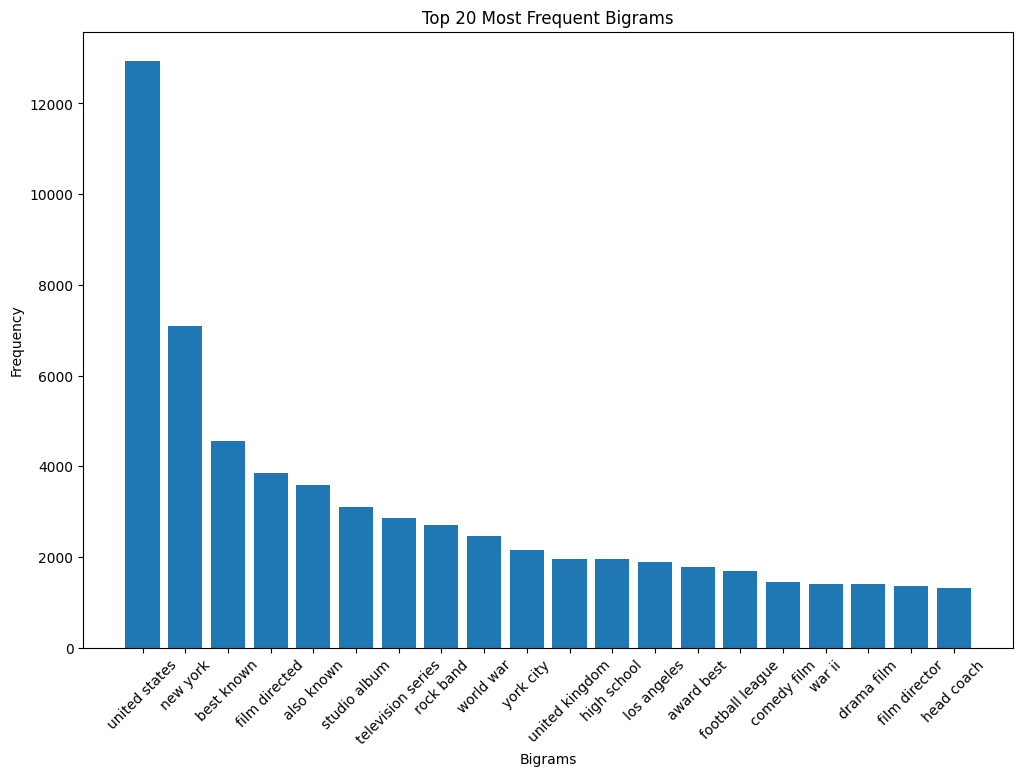

In [ ]:
most_common_bigrams = bigram_counts.most_common(20)
print("Most common bigrams:", most_common_bigrams)

bigram_words, bigram_counts = zip(*most_common_bigrams)
bigram_words = [' '.join(bigram) for bigram in bigram_words]
plt.figure(figsize=(12, 8))
plt.bar(bigram_words, bigram_counts)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Bigrams')
plt.xticks(rotation=45)
plt.show()

Trigrams

In [ ]:
# Frequency analysis for trigrams
def get_trigrams(texts):
    trigram_list = []
    for text in texts:
        tokens = [word for word in text.split() if word not in stop_words]
        trigrams = list(ngrams(tokens, 3))
        trigram_list.extend(trigrams)
    return trigram_list

In [ ]:
# Get all trigrams in the corpus
trigrams = get_trigrams(cleaned_corpus)

# Count the trigrams
trigram_counts = Counter(trigrams)

Most common trigrams: [(('new', 'york', 'city'), 2135), (('world', 'war', 'ii'), 1361), (('film', 'written', 'directed'), 847), (('national', 'football', 'league'), 827), (('1', '2', '3'), 787), (('drama', 'film', 'directed'), 729), (('2', '3', '4'), 713), (('comedy', 'film', 'directed'), 708), (('billboard', 'hot', '100'), 659), (('new', 'south', 'wales'), 655), (('american', 'rock', 'band'), 640), (('national', 'basketball', 'association'), 615), (('studio', 'album', 'american'), 603), (('academy', 'award', 'best'), 593), (('major', 'league', 'baseball'), 557), (('debut', 'studio', 'album'), 475), (('football', 'league', 'nfl'), 469), (('united', 'states', 'population'), 463), (('american', 'country', 'music'), 450), (('rock', 'band', 'formed'), 448)]


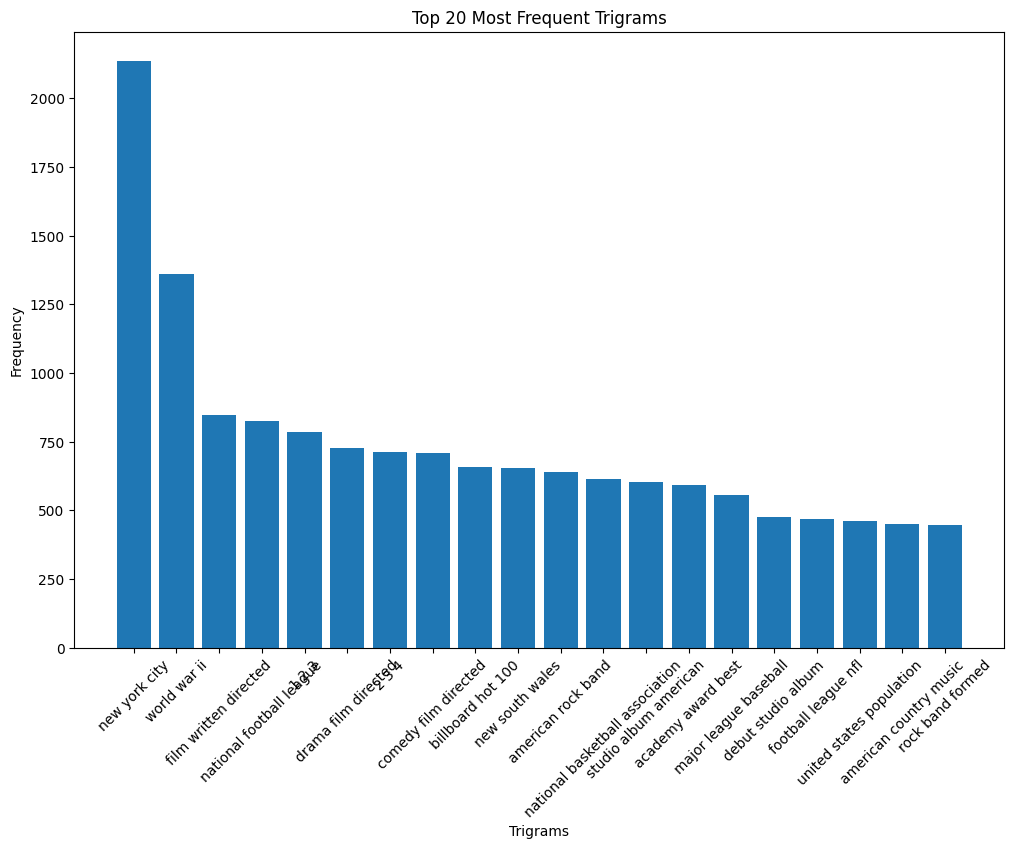

In [ ]:
# Display the most common trigrams
most_common_trigrams = trigram_counts.most_common(20)
print("Most common trigrams:", most_common_trigrams)

# Plotting the most common trigrams
trigram_words, trigram_counts = zip(*most_common_trigrams)
trigram_words = [' '.join(trigram) for trigram in trigram_words]
plt.figure(figsize=(12, 8))
plt.bar(trigram_words, trigram_counts)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Trigrams')
plt.xticks(rotation=45)
plt.show()

Length analysis

Distribution of doc length

In [ ]:
cleaned_corpus_1=cleaned_corpus

Document lengths: [20, 77, 25, 46, 11, 15, 64, 30, 58, 45, 48, 64, 42, 38, 51, 69, 32, 26, 26, 50, 27, 113, 71, 40, 82, 23, 31, 30, 118, 70, 51, 35, 49, 89, 24, 110, 130, 67, 51, 81, 148, 70, 13, 34, 51, 43, 66, 41, 52, 20, 29, 83, 97, 50, 20, 14, 24, 37, 60, 29, 40, 41, 56, 46, 33, 25, 25, 30, 51, 21, 59, 82, 48, 41, 28, 61, 26, 60, 47, 16, 70, 32, 29, 16, 45, 63, 103, 13, 27, 28, 40, 44, 21, 13, 39, 7, 13, 33, 55, 119, 21, 40, 28, 49, 17, 42, 98, 49, 12, 38, 55, 28, 70, 24, 21, 76, 70, 32, 21, 47, 54, 45, 75, 19, 47, 61, 51, 87, 62, 46, 17, 35, 35, 31, 35, 11, 14, 48, 76, 19, 43, 46, 29, 45, 25, 29, 62, 33, 16, 59, 35, 48, 48, 27, 83, 46, 42, 72, 65, 53, 35, 40, 62, 46, 53, 66, 53, 56, 93, 66, 40, 58, 41, 9, 28, 33, 31, 30, 45, 32, 26, 46, 90, 60, 83, 28, 16, 33, 56, 38, 57, 74, 21, 86, 79, 31, 29, 57, 30, 35, 83, 22, 15, 92, 65, 39, 26, 78, 45, 42, 10, 34, 68, 9, 32, 39, 20, 33, 25, 7, 12, 18, 14, 71, 70, 23, 44, 38, 45, 41, 29, 42, 42, 26, 67, 29, 35, 38, 29, 118, 34, 36, 17, 30, 1

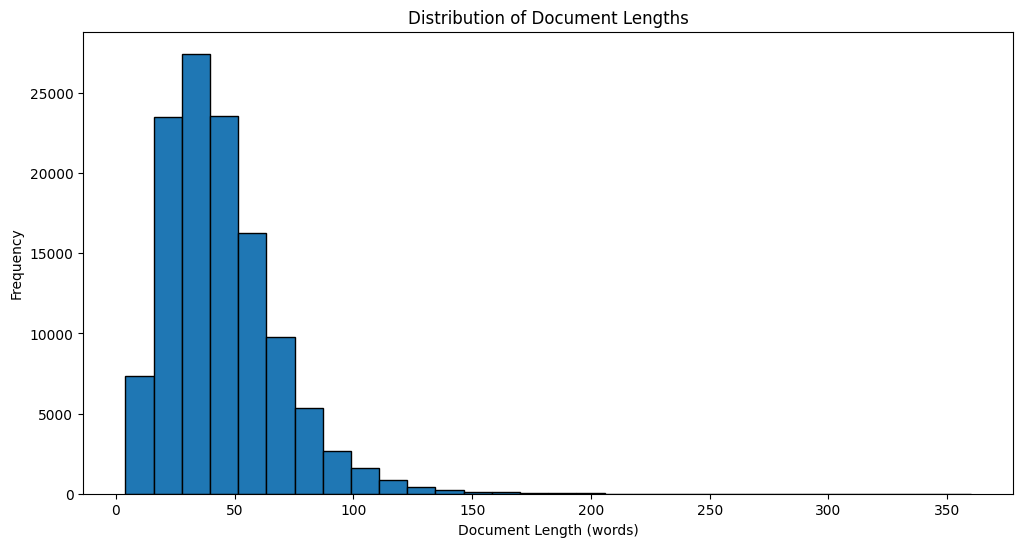

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the length of each document in words
document_lengths = [len(doc) for doc in cleaned_corpus_1]

# Print the lengths of the documents
print("Document lengths:", document_lengths)

# Compute and print basic statistics
average_length = np.mean(document_lengths)
median_length = np.median(document_lengths)
min_length = np.min(document_lengths)
max_length = np.max(document_lengths)

print(f"Average document length: {average_length}")
print(f"Median document length: {median_length}")
print(f"Minimum document length: {min_length}")
print(f"Maximum document length: {max_length}")

# Plot the distribution of document lengths
plt.figure(figsize=(12, 6))
plt.hist(document_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length (words)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from gensim.utils import simple_preprocess
# Tokenize the corpus
tokenized_corpus = [simple_preprocess(doc) for doc in cleaned_corpus_1]

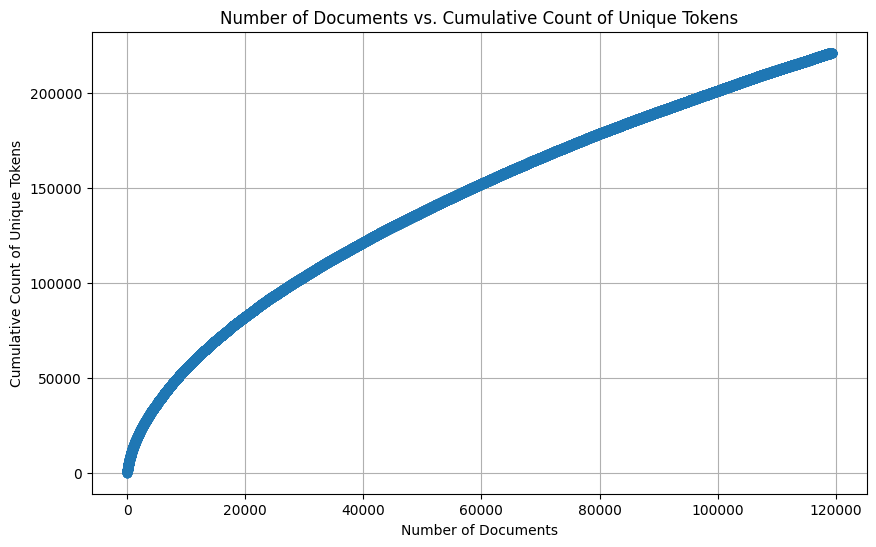

In [ ]:
# Track unique tokens
unique_tokens = set()
unique_counts = []

# Calculate the cumulative count of unique tokens
for i, tokens in enumerate(tokenized_corpus):
    unique_tokens.update(tokens)
    unique_counts.append(len(unique_tokens))

# Plot the number of documents against the cumulative count of unique tokens
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cleaned_corpus_1) + 1), unique_counts, marker='o', linestyle='-')
plt.xlabel('Number of Documents')
plt.ylabel('Cumulative Count of Unique Tokens')
plt.title('Number of Documents vs. Cumulative Count of Unique Tokens')
plt.grid(True)
plt.show()

In [ ]:
# Creating the corpus out of the json file titles
corpus_titles = context_string[0::2] # Removing the strings corresponding to titles
corpus_titles

['Edmund Burke',
 'Middle Ages',
 'Napoleon',
 'Indigenous peoples of the Americas',
 'Saw III',
 'Saw III',
 'Gregg Hoffman',
 'Architecture',
 'Tennessee',
 'Patricia Eddington',
 'Coram, New York',
 'Neil Harvey',
 'Ray Harvey',
 'Charleston, South Carolina',
 '24 Hours of LeMons',
 'Beyond Geek',
 'Bill Clinton',
 '1992 United States Senate elections',
 '1992 United States Senate elections',
 'V. S. Naipaul',
 "A Writer's People",
 'Dinosaur Jr.',
 'M83 (band)',
 'M83 (band)',
 'Northrop P-61 Black Widow',
 'M2 Browning',
 'M2 Browning',
 'Adolescence',
 'Asghar Farhadi',
 'Asghar Farhadi',
 'Michael Herz (producer)',
 'Horse-collar tackle',
 'Horse-collar tackle',
 'Roy Williams (safety)',
 'List of numbered streets in Manhattan',
 'Golden, Colorado',
 'Golden, Colorado',
 'Boston Market',
 'Boston Market',
 'Antibiotic',
 'Russian Soviet Federative Socialist Republic',
 'Jesus Army',
 'Noel Stanton',
 'Noel Stanton',
 'YouTube',
 'The Third Eye (TV series)',
 'Into the Labyrinth 

Removing Duplicates

In [ ]:
num_corpus_titles_before = len(corpus_titles)
print(f"Number of items in corpus before removing duplicates: {num_corpus_titles_before}")

# Remove duplicates
unique_corpus_titles = list(set(corpus_titles))

# Count the number of items in the corpus after removing duplicates
num_corpus_titles_after = len(unique_corpus_titles)
print(f"Number of items in corpus after removing duplicates: {num_corpus_titles_after}")

print("Unique corpus:", unique_corpus_titles[:10])

Number of items in corpus before removing duplicates: 236810
Number of items in corpus after removing duplicates: 89747
Unique corpus: ['Captain China', 'Khovanshchina', 'Claudio Reyna', 'Andrew Brackman', 'Carlitos (footballer, born March 1985)', 'Melissa Bank', 'The Third Eye (TV series)', 'Never Shout Never', 'The Alamo (1960 film)', 'PU scope']


In [ ]:
cleaned_corpus_titles = [clean_text(doc) for doc in unique_corpus_titles]

Average Titles Length

In [ ]:
# Calculate the length of each title in words
titles_lengths = [len(doc.split()) for doc in cleaned_corpus_titles]

# Compute the average title length
average_titles_length = np.mean(titles_lengths)

print("Average document length:", average_titles_length)

Average document length: 2.754699321425786


Vocabulary size in titles corpus

In [ ]:
# Calculate the vocabulary size
all_words_titles= [word for doc in cleaned_corpus_titles for word in doc.split()]
unique_words_titles = set(all_words_titles)
vocabulary_size_titles = len(unique_words_titles)
print("Vocabulary size:", vocabulary_size_titles)

Vocabulary size: 57920


In [ ]:
filtered_words_titles= [word for word in all_words_titles if word.lower() not in stop_words]
word_counts_titles = Counter(filtered_words_titles)

Our Title_Corpus has:
-Vocabulary size of : 57920
-Average title lenght of:2.75
-number of unique titles:89747


Most common unigrams in titles corpus

In [ ]:
most_common_words_titles = word_counts_titles.most_common(20)
print("Most common titles words:", most_common_words_titles)

Most common titles words: [('film', 3362), ('song', 1242), ('new', 1227), ('season', 1016), ('john', 919), ('album', 896), ('series', 785), ('football', 727), ('tv', 665), ('team', 599), ('university', 593), ('band', 573), ('york', 524), ('american', 499), ('south', 493), ('de', 467), ('game', 449), ('park', 447), ('world', 435), ('david', 432)]


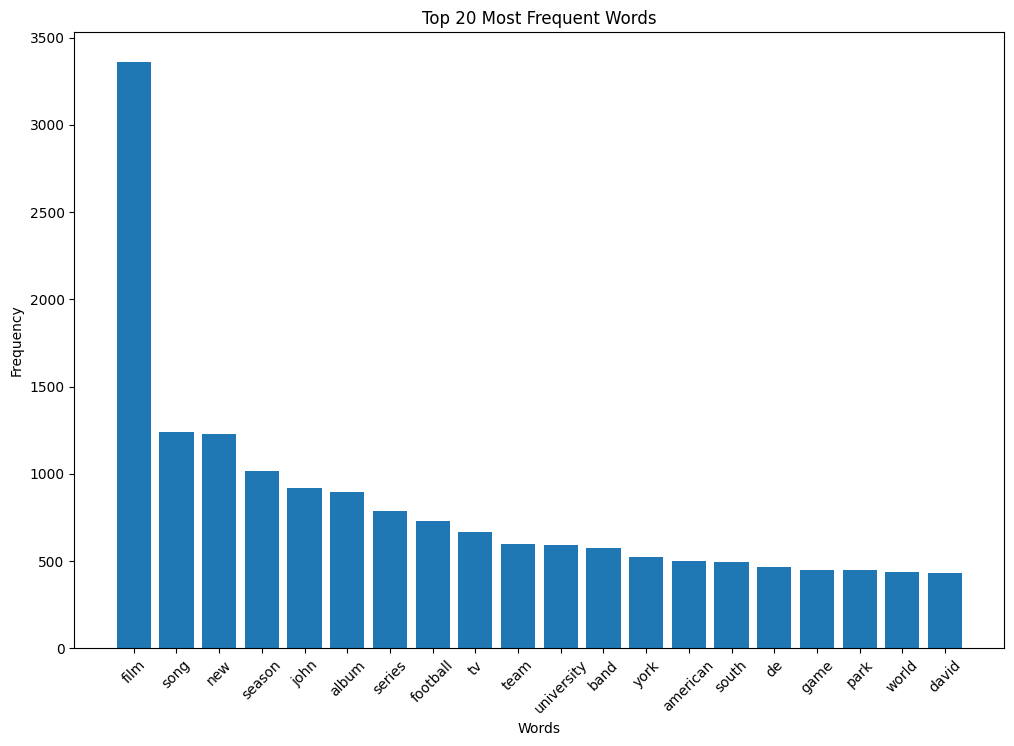

In [ ]:
words, counts = zip(*most_common_words_titles)
plt.figure(figsize=(12, 8))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

Bigram Analysis

In [ ]:
bigrams_titles = get_bigrams(cleaned_corpus_titles)


In [ ]:
bigram_counts_titles = Counter(bigrams_titles)


Most common titles  bigrams: [(('tv', 'series'), 561), (('new', 'york'), 495), (('football', 'team'), 404), (('united', 'states'), 239), (('new', 'hampshire'), 212), (('high', 'school'), 174), (('international', 'airport'), 143), (('new', 'south'), 138), (('south', 'wales'), 138), (('south', 'australia'), 120), (('grand', 'prix'), 116), (('mens', 'basketball'), 114), (('railway', 'station'), 111), (('basketball', 'team'), 104), (('american', 'football'), 103), (('video', 'game'), 95), (('fc', 'season'), 79), (('new', 'jersey'), 76), (('board', 'game'), 75), (('state', 'university'), 67)]


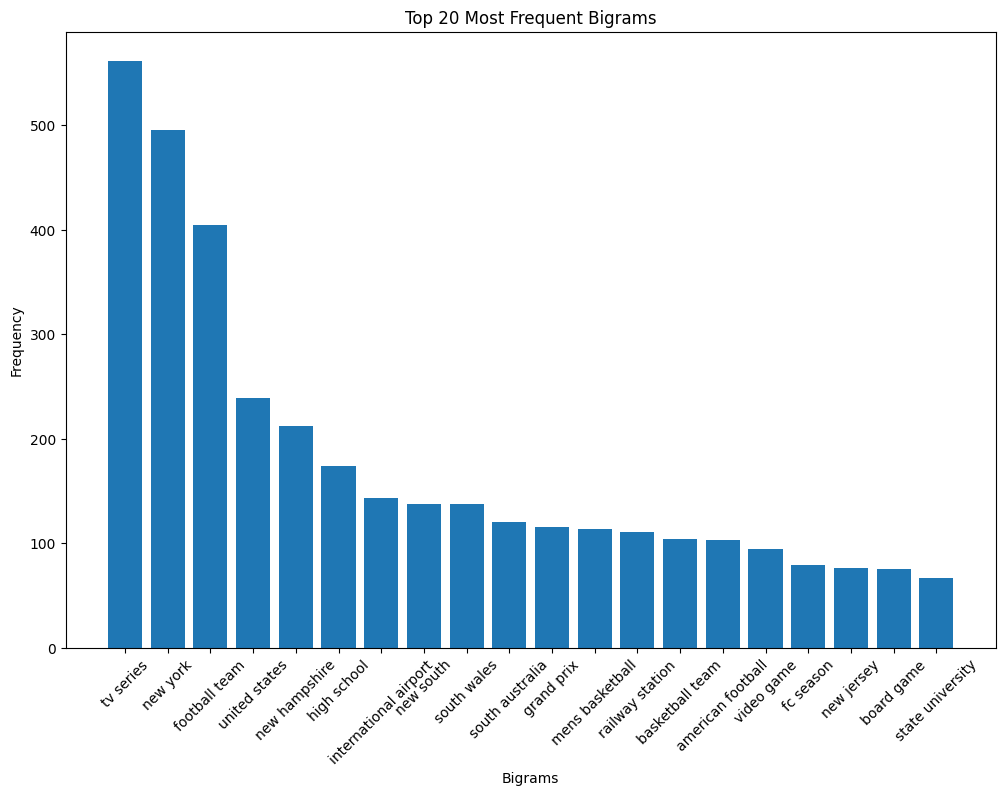

In [ ]:
most_common_bigrams_titles = bigram_counts_titles.most_common(20)
print("Most common titles  bigrams:", most_common_bigrams_titles)

bigram_words, bigram_counts = zip(*most_common_bigrams_titles)
bigram_words = [' '.join(bigram) for bigram in bigram_words]
plt.figure(figsize=(12, 8))
plt.bar(bigram_words, bigram_counts)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Bigrams')
plt.xticks(rotation=45)
plt.show()

Trigram Analysis

In [ ]:
# Get all trigrams in the corpus
trigrams_titles = get_trigrams(cleaned_corpus_titles)

# Count the trigrams
trigram_counts_titles = Counter(trigrams_titles)

Most common title trigrams: [(('new', 'south', 'wales'), 138), (('mens', 'basketball', 'team'), 75), (('united', 'states', 'senate'), 54), (('states', 'senate', 'election'), 50), (('new', 'york', 'state'), 45), (('uk', 'parliament', 'constituency'), 35), (('american', 'tv', 'series'), 32), (('york', 'state', 'route'), 30), (('fifa', 'world', 'cup'), 29), (('british', 'tv', 'series'), 29), (('national', 'football', 'team'), 28), (('tigers', 'football', 'team'), 26), (('air', 'force', 'base'), 26), (('pan', 'american', 'games'), 25), (('major', 'league', 'baseball'), 23), (('uefa', 'champions', 'league'), 21), (('oklahoma', 'sooners', 'football'), 21), (('south', 'park', 'season'), 20), (('new', 'york', 'city'), 20), (('sooners', 'football', 'team'), 20)]


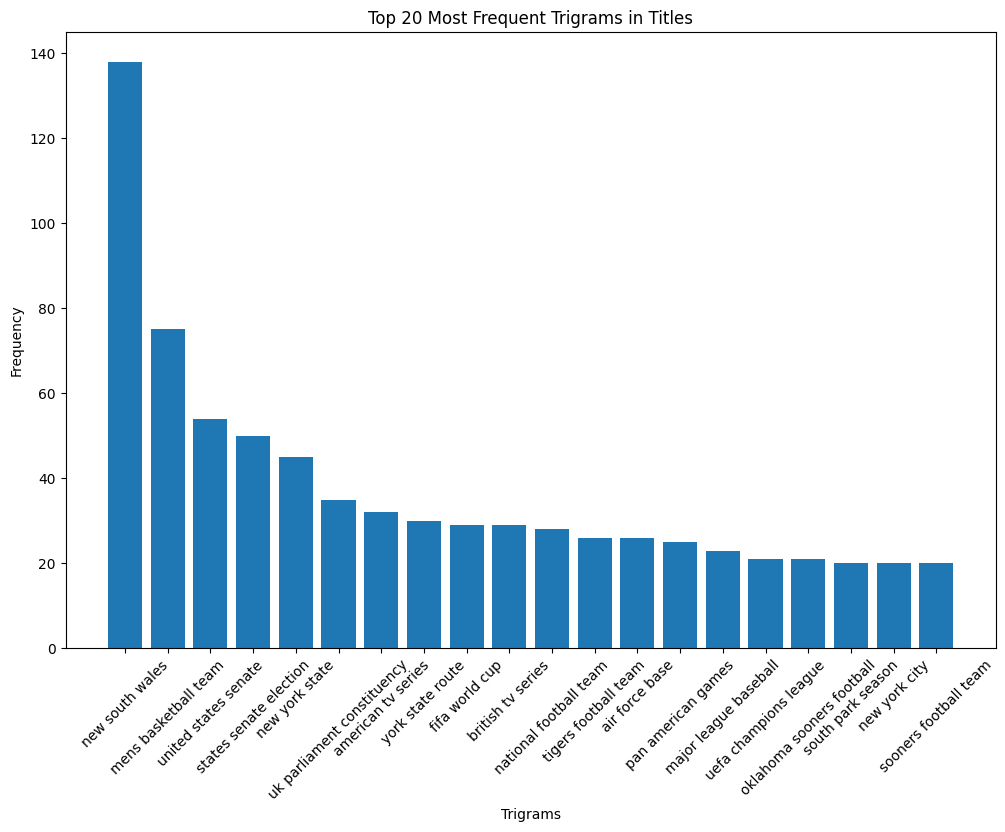

In [ ]:
# Assuming trigram_counts_titles is a Counter object containing the counts of trigrams in titles

# Find the 20 most common trigrams in titles
most_common_trigrams_titles = trigram_counts_titles.most_common(20)
print("Most common title trigrams:", most_common_trigrams_titles)

# Prepare the data for plotting
trigram_words, trigram_counts = zip(*most_common_trigrams_titles)
trigram_words = [' '.join(trigram) for trigram in trigram_words]

# Plot the most common trigrams
plt.figure(figsize=(12, 8))
plt.bar(trigram_words, trigram_counts)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Trigrams in Titles')
plt.xticks(rotation=45)
plt.show()


Length distribution analysis

In [ ]:
from gensim.utils import simple_preprocess
# Tokenize the corpus
tokenized_titles = [simple_preprocess(doc) for doc in cleaned_corpus_titles]

Average title length: 2.754699321425786
Median title length: 2.0
Minimum title length: 1
Maximum title length: 13


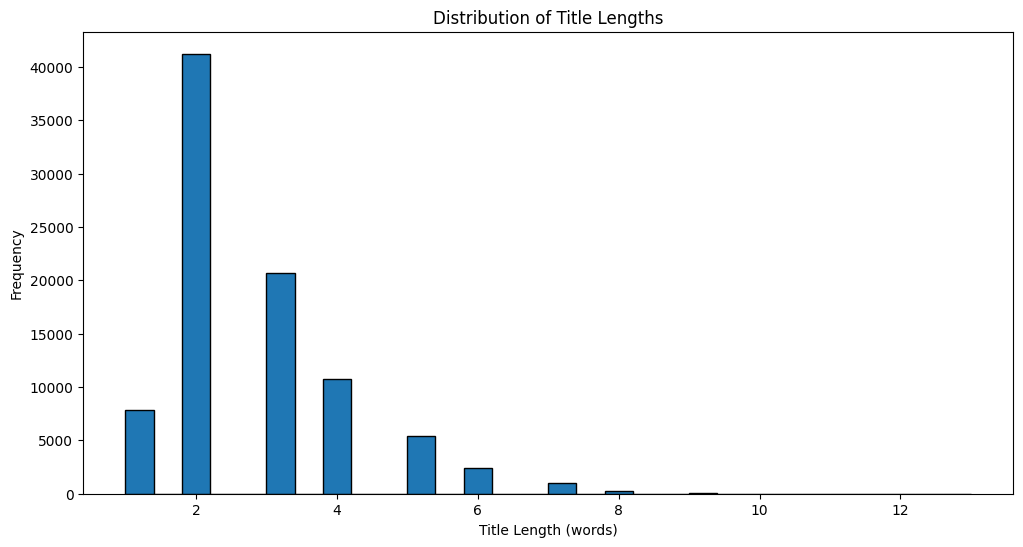

In [ ]:
average_length = np.mean(title_lengths)
median_length = np.median(title_lengths)
min_length = np.min(title_lengths)
max_length = np.max(title_lengths)

print(f"Average title length: {average_length}")
print(f"Median title length: {median_length}")
print(f"Minimum title length: {min_length}")
print(f"Maximum title length: {max_length}")

# Plot the distribution of title lengths
plt.figure(figsize=(12, 6))
plt.hist(title_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length (words)')
plt.ylabel('Frequency')
plt.show()

### Vectorizing and Clustering

Starting with titles

Generating the word embeddings for our documents, using Word2Vec with a vector size of 100.

In [ ]:
# Train Word2Vec model
import gensim
from gensim.models import Word2Vec


model = Word2Vec(sentences=tokenized_titles, vector_size=100, window=5, min_count=1, workers=4)

# Generate document embeddings by averaging word vectors
def document_vector(doc):
    # Remove out-of-vocabulary words and get the mean of the word vectors
    return np.mean([model.wv[word] for word in doc if word in model.wv.key_to_index], axis=0)
# Create document embeddings (you might need to exclude empty documents)
doc_embeddings_titles = np.array([document_vector(doc) for doc in tokenized_titles if len(doc) > 0])

Using only one hundred thousand of the embesings for computaional reasons

In [ ]:
#doc_embeddings=doc_embeddings[:10000,:]
doc_embeddings_titles=doc_embeddings[:100000,:]
doc_embeddings_titles.shape


(89644, 100)

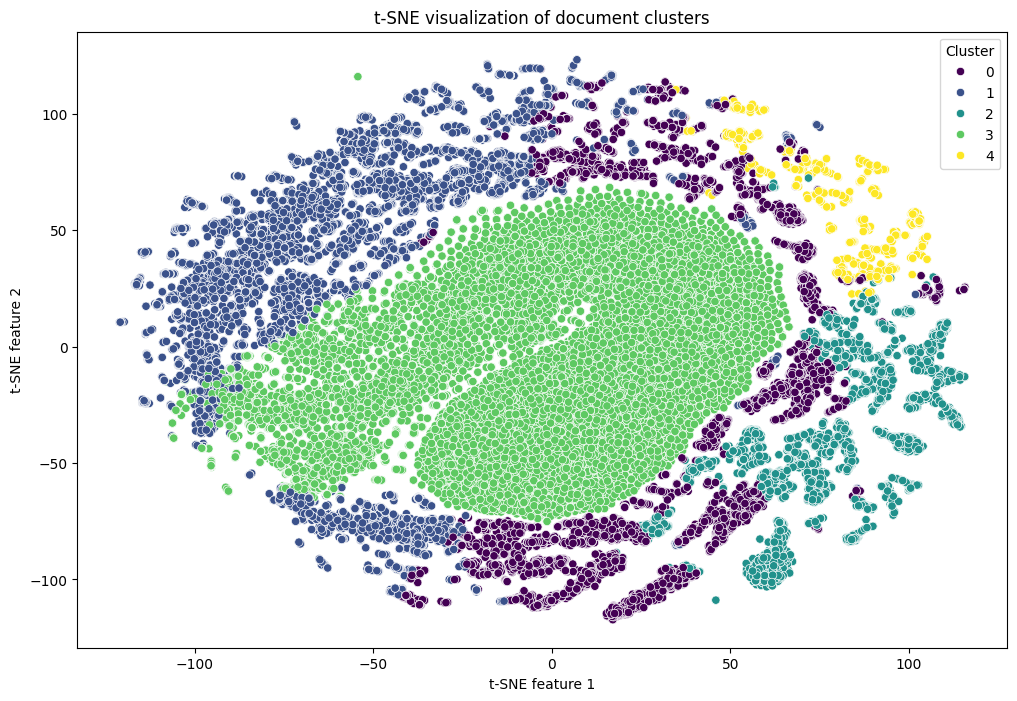

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Clustering with K-means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(doc_embeddings_titles)

# Dimensionality reduction with t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(doc_embeddings_titles)

# Plotting the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=clusters, palette='viridis')
plt.title('t-SNE visualization of document clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(loc='best', title='Cluster')
plt.show()

In [ ]:
from collections import Counter

def get_top_words_per_cluster(tokenized_corpus, clusters, top_n=10):
    cluster_words = {i: [] for i in range(len(set(clusters)))}
    for doc, cluster in zip(tokenized_corpus, clusters):
        cluster_words[cluster].extend(doc)
    top_words_per_cluster = {i: Counter(words).most_common(top_n) for i, words in cluster_words.items()}
    return top_words_per_cluster

top_words = get_top_words_per_cluster(tokenized_corpus, clusters)
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {', '.join([word for word, _ in words])}")


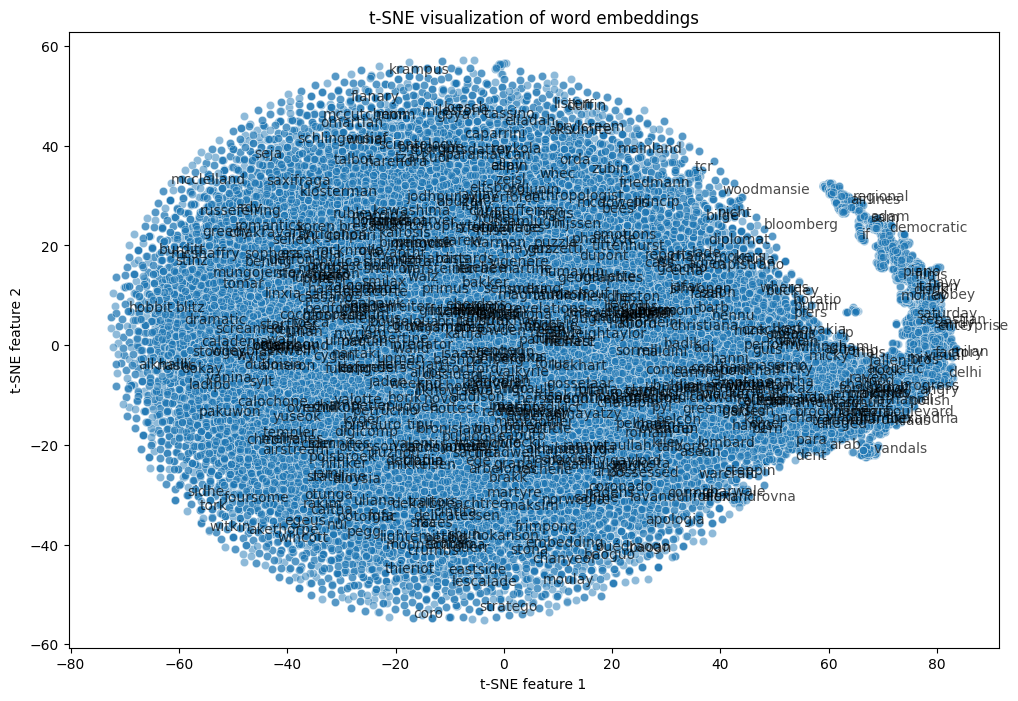

In [ ]:
# Visualizing Word Embeddings using t-SNE
words = list(model.wv.index_to_key)
word_vectors = np.array([model.wv[word] for word in words[:100000]])

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_reduced = tsne.fit_transform(word_vectors)

# Plotting the word embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(x=word_vectors_reduced[:, 0], y=word_vectors_reduced[:, 1], alpha=0.5)
plt.title('t-SNE visualization of word embeddings')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# Annotating a subset of words to keep the plot readable
for i, word in enumerate(words[:100000]):
    if np.random.random() < 0.01:  # Annotate roughly 1% of the words
        plt.annotate(word, xy=(word_vectors_reduced[i, 0], word_vectors_reduced[i, 1]), alpha=0.7)

plt.show()

Documents

Tf-Idf vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
vectorizer.fit(cleaned_corpus_1)

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
vector_documents = vectorizer.transform(cleaned_corpus_1)

In [ ]:
print(vector_documents[0])

  (0, 1335)	0.13172681500428376
  (0, 1345)	0.06474911164765648
  (0, 1354)	0.06322739274710908
  (0, 1363)	0.062457131427112594
  (0, 3721)	0.15655719243333135
  (0, 6252)	0.275247496181268
  (0, 6532)	0.08533410097911415
  (0, 6802)	0.05988415511594049
  (0, 7592)	0.1270846231017696
  (0, 10223)	0.086907473671057
  (0, 10913)	0.11687255118425013
  (0, 11701)	0.090309598485842
  (0, 11769)	0.1187524424404041
  (0, 12100)	0.08388491288704952
  (0, 12260)	0.08996853835131757
  (0, 12807)	0.21173304386569763
  (0, 13579)	0.08211922587695376
  (0, 14701)	0.071768640734558
  (0, 16857)	0.06525012285567271
  (0, 17106)	0.08912442807346983
  (0, 18417)	0.10150619108081145
  (0, 19146)	0.07531473745674179
  (0, 19272)	0.06979908810995077
  (0, 20174)	0.11421430043640057
  (0, 20532)	0.10209925872387837
  :	:
  (0, 39891)	0.084067163602662
  (0, 40126)	0.2110351917190729
  (0, 41601)	0.09612133017568723
  (0, 41792)	0.059906630768312624
  (0, 42097)	0.05292516162007875
  (0, 42117)	0.104845023

In [ ]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 52209


In [ ]:
import random

sorted(random.sample(vocab.tolist(),100))

['20162018',
 '756',
 'a41',
 'aborigines',
 'ahern',
 'aiguille',
 'aker',
 'allstate',
 'americano',
 'anne',
 'annoyed',
 'arthouse',
 'attribute',
 'baked',
 'browder',
 'canaveral',
 'carriers',
 'chronicling',
 'climbing',
 'copland',
 'coroner',
 'cricket',
 'daegu',
 'dc',
 'desirability',
 'dissonance',
 'dunst',
 'embodiment',
 'evangelistic',
 'executiveproduced',
 'expounded',
 'fabulous',
 'fairfax',
 'fda',
 'forrester',
 'fracturing',
 'fula',
 'guantanamo',
 'hamlets',
 'helium',
 'illegitimate',
 'imac',
 'imported',
 'inside',
 'isak',
 'jafar',
 'joo',
 'julie',
 'lendl',
 'lifeboat',
 'lists',
 'lucifer',
 'lukewarm',
 'ma',
 'magnitude',
 'margarets',
 'martius',
 'mid1850s',
 'missouris',
 'myles',
 'najm',
 'negligence',
 'node',
 'novelty',
 'nurtured',
 'obsessively',
 'ojibwe',
 'outlawz',
 'paperbacks',
 'pataki',
 'patriotic',
 'payton',
 'preserving',
 'probabilities',
 'randell',
 'ratchet',
 'recordbreaking',
 'refereed',
 'revolutionized',
 'revolve',
 '

In [ ]:
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

[('starred', 0.27286971335030563),
 ('foxs', 0.2186256709937556),
 ('lethal', 0.2163287097795416),
 ('payne', 0.2075369783436222),
 ('cop', 0.2038129639648665),
 ('scout', 0.1977033253622868),
 ('damon', 0.19728977369045989),
 ('weapon', 0.19331611772398485),
 ('beverly', 0.18928502334392117),
 ('television', 0.18728236704800616),
 ('sketch', 0.18620614516472483),
 ('kids', 0.1779766689974052),
 ('series', 0.1773709179931685),
 ('breakthrough', 0.17668387112788006),
 ('performer', 0.17411992589089106),
 ('roger', 0.16375978506163616),
 ('color', 0.16265697183615604),
 ('hills', 0.16016518808870342),
 ('true', 0.153259935392702),
 ('sitcom', 0.14946881342429275),
 ('boy', 0.14468083390375078),
 ('living', 0.14146550723524842),
 ('wife', 0.13451134626250605),
 ('tv', 0.13351403833999329),
 ('shows', 0.13203593738156003),
 ('came', 0.13042689458526655),
 ('1990', 0.12990812321695488),
 ('1992', 0.1287820983040165),
 ('1998', 0.12482700279247967),
 ('2019', 0.1237735193970986),
 ('writer',

In [ ]:
for i in range(1,200):
  print(f'Similarity with {i}:', vector_documents[0].multiply(vector_documents[i]).sum())

Similarity with 1: 0.0
Similarity with 2: 0.0071498296330314084
Similarity with 3: 0.012800235074723504
Similarity with 4: 0.0
Similarity with 5: 0.0
Similarity with 6: 0.0
Similarity with 7: 0.0
Similarity with 8: 0.01256624719348929
Similarity with 9: 0.02037176659153289
Similarity with 10: 0.0
Similarity with 11: 0.021757044166956896
Similarity with 12: 0.0098349541753559
Similarity with 13: 0.0
Similarity with 14: 0.004152755698491485
Similarity with 15: 0.03674042795804858
Similarity with 16: 0.0
Similarity with 17: 0.0035559556275981605
Similarity with 18: 0.009462050548916811
Similarity with 19: 0.008556579168204459
Similarity with 20: 0.00451220262494987
Similarity with 21: 0.0175872934145872
Similarity with 22: 0.0
Similarity with 23: 0.0
Similarity with 24: 0.0
Similarity with 25: 0.01579836988323756
Similarity with 26: 0.0
Similarity with 27: 0.0
Similarity with 28: 0.01595418091706035
Similarity with 29: 0.00976642994111895
Similarity with 30: 0.006956000517077876
Similarit

In [ ]:
# Train Word2Vec model
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
# Tokenize the corpus
tokenized_corpus = [simple_preprocess(doc) for doc in cleaned_corpus_1]

model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Generate document embeddings by averaging word vectors
def document_vector(doc):
    # Remove out-of-vocabulary words and get the mean of the word vectors
    return np.mean([model.wv[word] for word in doc if word in model.wv.key_to_index], axis=0)



In [ ]:
# Create document embeddings (you might need to exclude empty documents)
doc_embeddings = np.array([document_vector(doc) for doc in tokenized_corpus if len(doc) > 0])

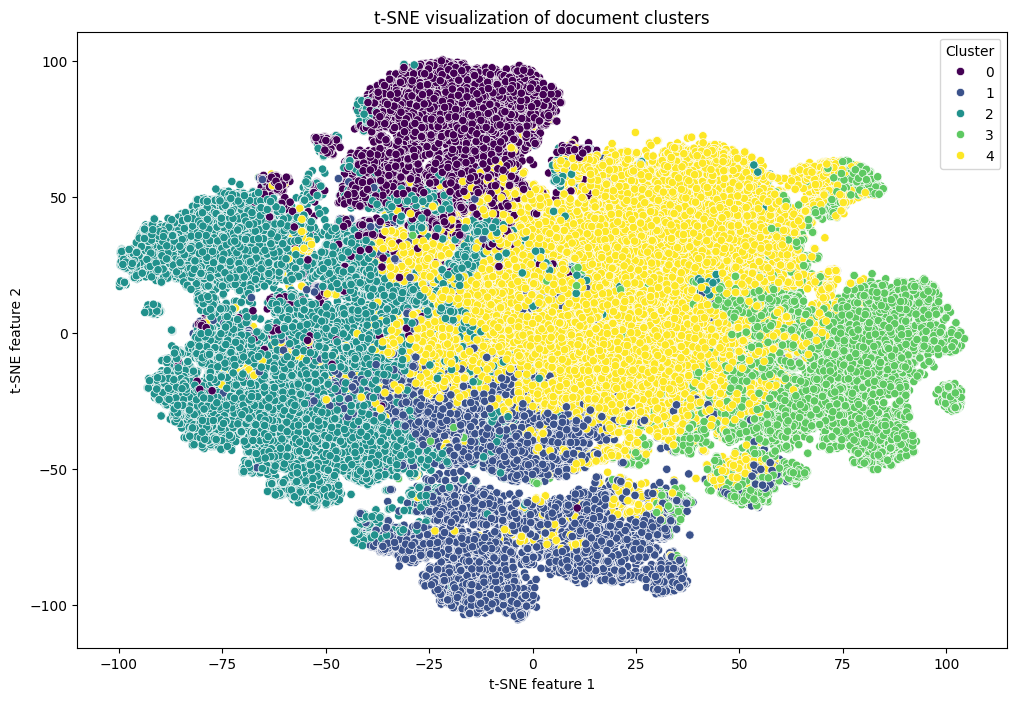

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Clustering with K-means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(doc_embeddings)

# Dimensionality reduction with t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(doc_embeddings)

# Plotting the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=clusters, palette='viridis')
plt.title('t-SNE visualization of document clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(loc='best', title='Cluster')
plt.show()

# One-Hop Question Answering

Variable-hop question answering can be thought of as the implementation of an iterative retrieval-augmented generative model. Therefore, our first step is to work on creating one that will be our base.

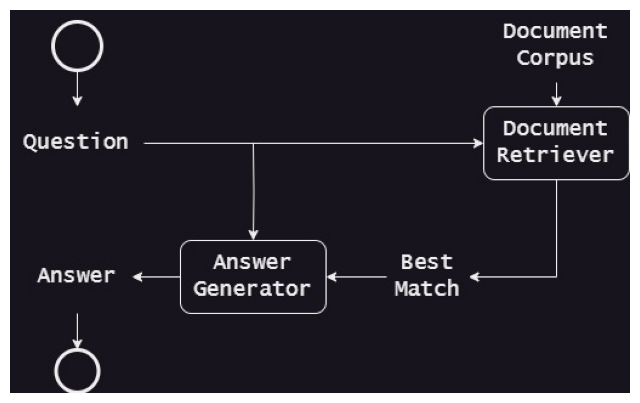

In [ ]:
image_path = '/content/drive/MyDrive/proj-nlp-2024/doc/one_hop_base.jpg'
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Document Retriever

### Lexical Search

In [ ]:
# Importing terrier and starting it
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.9 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



In [ ]:
# Creating a dataframe containing the corpus for indexing
df = pd.DataFrame({'context':corpus})
df = df.assign(docno = range(0, len(df))).astype(str)

In [ ]:
# Indexing the corpus
index_path = "./index_beerqa_train"

# Check if the index directory exists
if os.path.exists(index_path):
    # Load the existing index
    index_ref = pt.IndexFactory.of(index_path)
else:
    # Create a new index
    indexer = pt.DFIndexer(index_path, overwrite=True)
    index_ref = indexer.index(df["context"], df["docno"])
index = index_ref
print(index.toString())
print(index.getCollectionStatistics().toString()) #get some info about the dataset

/content/drive/MyDrive/proj-nlp-2024/data/index_beerqa_train/data.properties
Number of documents: 119314
Number of terms: 154451
Number of postings: 4500589
Number of fields: 0
Number of tokens: 5484261
Field names: []
Positions:   false



In [ ]:
# Trying lexical search with a given query
query = 'napoleon'

# Use different retrievers
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

print('TF IDF:')
print(tf_idf.search(query))
print('\nBM25:')
print(bm25.search(query))

# Making a new retriever
composition = (tf_idf % 50 | tf % 50) >> bm25 # combine the top 50 results from tf_idf and tf, then rerank them with bm25

print('\nCustom:')
print(composition.search(query))

TF IDF:
    qid   docid   docno  rank     score     query
0     1   38982   38982     0  8.466551  napoleon
1     1   24908   24908     1  8.224827  napoleon
2     1   70537   70537     2  8.216448  napoleon
3     1   22152   22152     3  8.201675  napoleon
4     1    7486    7486     4  8.083406  napoleon
..   ..     ...     ...   ...       ...       ...
274   1    8602    8602   274  3.108398  napoleon
275   1   72245   72245   275  2.921956  napoleon
276   1   58475   58475   276  2.890434  napoleon
277   1  100226  100226   277  2.634636  napoleon
278   1    3988    3988   278  2.571423  napoleon

[279 rows x 6 columns]

BM25:
    qid   docid   docno  rank      score     query
0     1   38982   38982     0  15.505458  napoleon
1     1   24908   24908     1  15.062769  napoleon
2     1   70537   70537     2  15.047425  napoleon
3     1   22152   22152     3  15.020369  napoleon
4     1    7486    7486     4  14.803773  napoleon
..   ..     ...     ...   ...        ...       ...
274 

We move on to semantic search. This way we can better grasp the meaning content of both the question and passages. Moreover using different expressions with the same meaning won't change the retrieved passages.

### Semantic Search

We use the all-mpnet-base-v2 sentence transofmer to embed the documents to a 768 dimensional dense vector space

In [ ]:
semb_model = SentenceTransformer('all-mpnet-base-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating the corpus embeddings

In [ ]:
# corpus_path = f'{data_path}/corpus3_embeddings.pkl'
# if os.path.exists(corpus_path):
#   # Load the corpus
#   with open(corpus_path, 'rb') as f:
#     corpus_embeddings = pickle.load(f)
# else:
#   # Embedding the corpus
#   corpus_embeddings = semb_model.encode(corpus, convert_to_tensor=True, show_progress_bar=True)
#   index_dim = corpus_embeddings.size(1)
#   # Saving the corpus
#   with open(corpus_path, 'wb') as f:
#     pickle.dump(corpus_embeddings, f)

Creating the corpus embeddings index

In [ ]:
index_path = f'{data_path}/corpus3_hnswlib.index'
if os.path.exists(index_path):
  # Loading the corpus embeddings index
  index = hnswlib.Index(space='cosine', dim=768) # index_dim=768
  index.load_index(index_path)
else:
  # Indexing the embeddings
  index = hnswlib.Index(space='cosine', dim=index_dim)
  index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=400, M=64)
  index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
  index.save_index(index_path) # Saving the corpus embeddings index

To implement semantic search we use a cross encoder to re-embed the top ranking documents retrieved through cosine similarity

In [ ]:
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def semantic_search(
  question,
  corpus=corpus,
  similarity_model=semb_model,
  embeddings_index=index,
  re_ranking_model=xenc_model
):
  if not question.endswith('?'):
      question = question + '?'
  # Embed question
  question_embedding = similarity_model.encode(question, convert_to_tensor=True)
  # Search documents similar to question in index
  corpus_ids, distances = embeddings_index.knn_query(question_embedding.cpu(), k=128) # Finding out the best hyperparameter
  # Re-rank results
  re_ranker_inputs = [(question, corpus[idx]) for idx in corpus_ids[0]]
  cross_scores = re_ranking_model.predict(re_ranker_inputs)
  # Get best matching passage
  passage_idx = np.argsort(-cross_scores)[0]
  passage = corpus[corpus_ids[0][passage_idx]]
  # Return passage
  return passage

Example

In [ ]:
row = 4
question = df_hotpotqa['question'].iloc[row]
# Retrieve the passage most relevant to the question
passage = semantic_search(question)
print(f"Question: {question}\n\nPassage: {passage}")

Question: Who co-wrote the song "Let's Make a Night to Remember" with a South African record producer and songwriter?

Passage: "Let's Make a Night to Remember" is a song written by Canadian rock artist Bryan Adams, and Robert John "Mutt" Lange. It was recorded by Adams and released in August 1996 as the second single from his album, "18 til I Die". The song's musical-style and production were heavily inspired by rock and pop music from the 1980s, and its lyrics chronicle a relationship.


##  Answer Generator

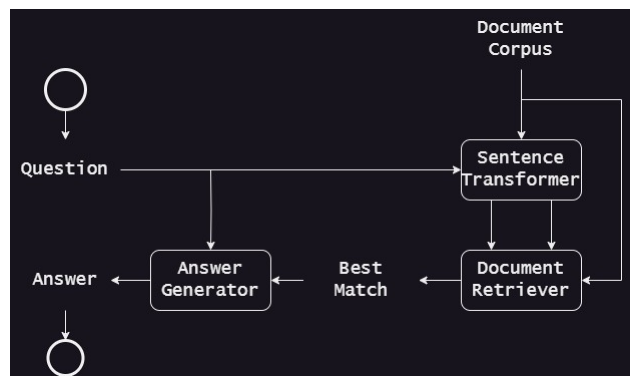

In [ ]:
image_path = '/content/drive/MyDrive/proj-nlp-2024/doc/one-hop_question_answering.jpg'
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Defining the transformer-based answer generation pipeline

In [ ]:
def answer_generation(
  request,
  tokenizer,
  generative_model,
  device=device
):
  # Encode input
  input_ids = tokenizer(request, return_tensors="pt").input_ids.to(device)
  # Generate output
  output_ids = generative_model.generate(input_ids, max_new_tokens=32)
  # Decode output
  answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
  # Return answer
  return answer

From the following models, we selected the best-performing one as the base retrieval-augmented generative model for building the variable-hop question-answering system.

### Google's T5 Pre-Trained

Loading the model

In [ ]:
tokenizer_t5 = T5Tokenizer.from_pretrained("google/flan-t5-large")
model_t5 = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="cuda", torch_dtype=torch.bfloat16)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
row = 4
question = df_hotpotqa['question'].iloc[row]
# Retrieve the passage most relevant to the question
passage = semantic_search(question)
# Generate the answer out of the question and passage
input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
answer = answer_generation(input_text, tokenizer=tokenizer_t5, generative_model=model_t5)
# Retrieve correct answer
correct = df_hotpotqa['answers'].iloc[row]
print(f"Question: {question}\n\nPassage: {passage}\n\nPredicted answer: {answer}\n\nCorrect answer: {correct}")

Question: Who co-wrote the song "Let's Make a Night to Remember" with a South African record producer and songwriter?

Passage: "Let's Make a Night to Remember" is a song written by Canadian rock artist Bryan Adams, and Robert John "Mutt" Lange. It was recorded by Adams and released in August 1996 as the second single from his album, "18 til I Die". The song's musical-style and production were heavily inspired by rock and pop music from the 1980s, and its lyrics chronicle a relationship.

Predicted answer: Bryan Adams

Correct answer: Bryan Adams


Defining the one-hop question answering pipeline as a single function to run predictions with

In [ ]:
def pipeline_t5(question):
  passage = semantic_search(question)
  input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
  answer = answer_generation(input_text, tokenizer=tokenizer_t5, generative_model=model_t5)
  return answer

### OpenAI's GPT-2 Fine-Tuned

Loading the fine-tuned model from memory

In [ ]:
# Load the model state dictionary from the .pkl file
with open("/content/drive/MyDrive/proj-nlp-2024/fine_tuned_gpt2.pkl", 'rb') as f:
    state_dict = pickle.load(f)

# Create a new instance of the GPT-2 model
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
# Load the state dictionary into the model
model_gpt2.load_state_dict(state_dict)
# Move the model to the device
model_gpt2.to(device)
# Set the model to evaluation mode
model_gpt2.eval()
# Load tokenizer
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
row = 4
question = df_hotpotqa['question'].iloc[row]
# Retrieve the passage most relevant to the question
passage = semantic_search(question)
# Generate the answer out of the question and passage
input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
answer = answer_generation(input_text, tokenizer=tokenizer_gpt2, generative_model=model_gpt2)
# Extract only the part after "A:"
answer_start = answer.find("A:")
if answer_start != -1:
  answer = answer[answer_start + 2:].strip()
# Retrieve correct answer
correct = df_hotpotqa['answers'].iloc[row]
print(f"Question: {question}\n\nPassage: {passage}\n\nPredicted answer: {answer}\n\nCorrect answer: {correct}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Who co-wrote the song "Let's Make a Night to Remember" with a South African record producer and songwriter?

Passage: "Let's Make a Night to Remember" is a song written by Canadian rock artist Bryan Adams, and Robert John "Mutt" Lange. It was recorded by Adams and released in August 1996 as the second single from his album, "18 til I Die". The song's musical-style and production were heavily inspired by rock and pop music from the 1980s, and its lyrics chronicle a relationship.

Predicted answer: Bryan Adams

Correct answer: Bryan Adams


In [ ]:
def pipeline_gpt2(question):
  passage = semantic_search(question)
  input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
  answer = answer_generation(input_text, tokenizer=tokenizer_gpt2, generative_model=model_gpt2)
  # Extract only the part after "A:"
  answer_start = answer.find("A:")
  if answer_start != -1:
    answer = answer[answer_start + 2:].strip()
  return answer

#### GPT-2 Fine-Tuning

In [ ]:
# #How GPT2 has been finetuned
# #Creating the Dataset class used for the pytorch training loop
# class QADataset(Dataset):
#     def __init__(self, data, tokenizer):
#         self.data = data
#         self.tokenizer = tokenizer

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         #Extracting data from dataset
#         sample = self.data[idx]
#         context = sample['context'][0][1]
#         question = sample['question']
#         answer = sample['answers'][0]

#         #Create the input text and target text
#         input_text = f"{context}\nQ: {question}\nA: {answer}"
#         target_text = input_text

#         #Tokenize the input and target text
#         input_ids = self.tokenizer.encode(input_text, return_tensors='pt').squeeze()
#         target_ids = input_ids.clone()

#         return {
#             'input_ids': input_ids,
#             'target_ids': target_ids
#         }

# #This function is used to prepare a batch of data for the model during training or evaluation.
# def collate_fn(batch):
#     #Extract 'input_ids' from each item in the batch, but only if the 'input_ids' list is not empty.
#     input_ids = [item['input_ids'] for item in batch if len(item['input_ids']) > 0]
#     #Extract 'target_ids' from each item in the batch, but only if the 'target_ids' list is not empty.
#     target_ids = [item['target_ids'] for item in batch if len(item['target_ids']) > 0]

#     #If there are no valid input_ids or target_ids, return None.
#     if len(input_ids) == 0 or len(target_ids) == 0:
#         return None

#     #Pad the input sequences to the same length using the padding token ID.
#     input_ids = rnn_utils.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
#     #Pad the target sequences to the same length using the padding token ID.
#     target_ids = rnn_utils.pad_sequence(target_ids, batch_first=True, padding_value=tokenizer.pad_token_id)

#     #Create attention masks. The attention mask has 1s for real tokens and 0s for padding tokens.
#     attention_mask = (input_ids != tokenizer.pad_token_id).long()

#     #Return a dictionary containing the padded input IDs, target IDs, and attention masks.
#     return {
#         'input_ids': input_ids,
#         'target_ids': target_ids,
#         'attention_mask': attention_mask
#     }


In [ ]:
# # Load the tokenizer
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# tokenizer.padding_side = 'left'
# tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos token


# #Create a DataLoader used in the training loop
# data = train_dataset['data']
# qa_dataset = QADataset(data, tokenizer)
# dataloader = DataLoader(qa_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [ ]:
# #Load the GPT-2 model and move it to the GPU
# model = GPT2LMHeadModel.from_pretrained('gpt2')
# model.resize_token_embeddings(len(tokenizer))  #Resizing embeddings
# model.to(device)
# model.train()

# #Optimizer
# optimizer = AdamW(model.parameters(), lr=5e-5) #Note that for finetuning a low learning rate was used

# #Training loop using the instance of the dataloader
# epochs = 3
# for epoch in range(epochs):
#     for batch in tqdm(dataloader):
#         if batch is None:
#             continue

#         optimizer.zero_grad()

#         input_ids = batch['input_ids'].to(device)
#         target_ids = batch['target_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)

#         #Optional printing to debug shapes
#         #print(f"Input shape: {input_ids.shape}, Target shape: {target_ids.shape}")

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target_ids)
#         loss = outputs.loss

#         loss.backward()
#         optimizer.step()

#     print(f"Epoch: {epoch}, Loss: {loss.item()}")

In [ ]:
# # Evaluation function, to be used for a fixed number of batches for visualization purposes
# def evaluate_model(model, dataloader, tokenizer, device, max_new_tokens=50, num_batches=1):
#     model.eval()
#     total_loss = 0
#     total_batches = 0
#     extracted_questions = []
#     extracted_answers = []

#     with torch.no_grad():
#         for batch in dataloader:
#             if batch is None:
#                 continue

#             input_ids = batch['input_ids'].to(device)
#             target_ids = batch['target_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target_ids)
#             loss = outputs.loss
#             total_loss += loss.item()
#             total_batches += 1

#             # Generate responses
#             generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=max_new_tokens)
#             generated_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
#             target_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in target_ids]

#             for generated_text in generated_texts:
#                 # Split the generated text into question and answer parts
#                 if "Q:" in generated_text and "A:" in generated_text:
#                     split_text = generated_text.split("A:")
#                     question_part = split_text[0].strip()
#                     answer_part = split_text[1].strip()

#                     if "Q:" in question_part:
#                         question = question_part.split("Q:")[1].strip()
#                     else:
#                         question = ""

#                     answer = answer_part

#                     print(f"Question: {question}")
#                     print(f"Generated Answer: {answer}")
#                     print()

#                     extracted_questions.append(question)
#                     extracted_answers.append(answer)

#             if total_batches >= num_batches:
#                 break

#     avg_loss = total_loss / total_batches
#     return avg_loss, extracted_questions, extracted_answers

# # Perform evaluation
# max_new_tokens = 50  # You can adjust this value based on your task requirements
# num_batches = 1  # Number of batches to process
# avg_loss, questions, answers = evaluate_model(model, dataloader, tokenizer, device, max_new_tokens, num_batches)

# # Print the results
# print(f"Average Loss: {avg_loss}")
# print(f"Questions: {questions}")
# print(f"Answers: {answers}")

### Microsoft's Phi-3 Mini Pre-Trained

In [ ]:
model_phi3 = AutoModelForCausalLM.from_pretrained(
  "microsoft/Phi-3-mini-4k-instruct", # context_size=4k
  device_map="cuda",
  torch_dtype="auto",
  trust_remote_code=True,
)
tokenizer_phi3 = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
pipe = pipeline(
  "text-generation",
  model=model_phi3,
  tokenizer=tokenizer_phi3,
)

generation_args = {
  "max_new_tokens": 50,
  "return_full_text": False,
  "temperature": 0.3,
  "do_sample": True,
}

def chatbot(user_request):
  system_prompt = "You are a question-answering chatbot."
  messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_request},
    ]
  output = pipe(messages, **generation_args)
  return output[0]['generated_text']

Asking a question from the training set

In [ ]:
row = 5
question = df_hotpotqa['question'].iloc[row]
# Retrieve the passage most relevant to the question
passage = semantic_search(question)
# Generate the answer out of the question and passage
input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
answer = chatbot(input_text)
# Retrieve correct answer
correct = df_hotpotqa['answers'].iloc[row]
print(f"Question: {question}\n\nPassage: {passage}\n\nPredicted answer: {answer}\n\nCorrect answer: {correct}")

Question: What is the name of the parent company of the record label that Gold was released through?

Passage: Gold is the debut extended play by Los Angeles-based indie pop band, Sir Sly. It was released through Interscope Records on May 21, 2013.

Predicted answer:  The name of the parent company of the record label that Gold was released through is Interscope Records. However, the parent company of Interscope Records is Universal Music Group. Therefore, the parent company of the record label that Gold was released through

Correct answer: Universal Music Group


Asking a question outside of the training set

In [ ]:
question = "How many fingers in a hand?"
# Retrieving the best match paragraph
passage = semantic_search(question)
# Prompting the Phi-3 Mini model
input_text = "Answer the user question: '" + question + "' \n\n based on the information in the document: \n```\n" + passage + "\n```\n\n"
answer = chatbot(input_text)
print(f"Question: {question}\n\nPassage: {passage}\n\nAnswer: {answer}")

Question: How many fingers in a hand?

Passage: 5 Fingers, known also as Five Fingers, is a 1952 American spy film directed by Joseph L. Mankiewicz and produced by Otto Lang. The screenplay by Michael Wilson was based on the book "Operation Cicero" (Original German: "Der Fall Cicero") (1950) by Ludwig Carl Moyzisch, Nazi commercial attaché at the German Embassy in Ankara (1943–44). In the film, James Mason plays Ulysses Diello (Cicero), the character based on Elyesa Bazna. The rest of the cast includes Danielle Darrieux, Michael Rennie, Herbert Berghof and Walter Hampden.

Answer:  There are 5 fingers in a hand. However, the provided document does not mention this information directly. It is a general knowledge fact not related to the content of the document. The document is about a 1952 American spy film


The Phi-3 model outperforms even text retrieval, with more coherent information embedded in its parameters than in the entire corpus.

Maybe we can try to use the model to act as an answer classifier for the iterative implementation of the model.

### Evaluation

Running and scoring predictions with the pre-trained T5

In [ ]:
# Squad
path = f'{data_path}/squad_predictions_t5_dataframe.csv'
df_squad_t5 = run_predictions(df_squad, path, pipeline_t5)
print("---------------------------------------------------------------")
print('Squad T5')
score_predictions(df_squad_t5)

# Hotpotqa
path = f'{data_path}/hotpotqa_predictions_t5_dataframe.csv'
df_hotpotqa_t5 = run_predictions(df_hotpotqa, path, pipeline_t5)
print("---------------------------------------------------------------")
print('Hotpotqa T5')
score_predictions(df_hotpotqa_t5)

---------------------------------------------------------------
Squad T5
F1: 0.7085946243300961
EM: 0.59
---------------------------------------------------------------
Hotpotqa T5
F1: 0.45685291571173925
EM: 0.386


Running predictions with the fine-tuned GPT-2

In [ ]:
import warnings

warnings.filterwarnings("ignore")

# Squad
path = f'{data_path}/squad_predictions_gpt2_dataframe.csv'
df_squad_gpt2 = run_predictions(df_squad, path, pipeline_gpt2)
print("---------------------------------------------------------------")
print('Squad GPT-2')
score_predictions(df_squad_gpt2)

# Hotpotqa
path = f'{data_path}//hotpotqa_predictions_gpt2_dataframe.csv'
df_hotpotqa_gpt2 = run_predictions(df_hotpotqa, path, pipeline_gpt2)
print("---------------------------------------------------------------")
print('Hotpotqa GPT-2')
score_predictions(df_hotpotqa_gpt2)

---------------------------------------------------------------
Squad GPT-2
F1: 0.5501423123320623
EM: 0.408
---------------------------------------------------------------
Hotpotqa GPT-2
F1: 0.38854690783073137
EM: 0.312


# Failed Attempts at Variable-Hop Question Answering

The following was the initial blueprint of our architecture

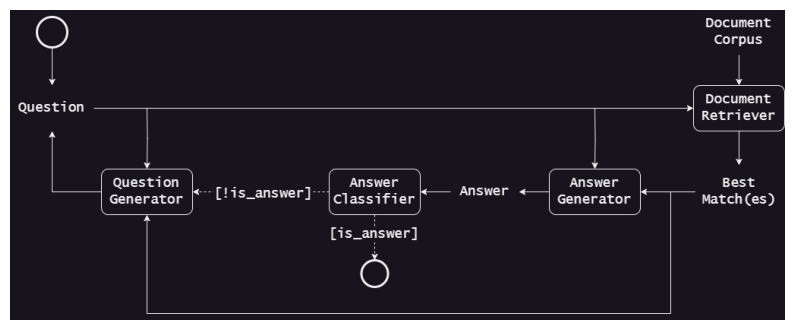

In [ ]:
image_path = '/content/drive/MyDrive/proj-nlp-2024/doc/initial_blueprint.jpg'
img = mpimg.imread(image_path)
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

After finalizing the RAG component, we focused on implementing both an answer classifier and a new question generator. Here are some notable failed attempts.

## Answer classifier: question-answer cosine similarity

Trying to understand whether cosine similarity between the embeddings of the answer and the question could be a metric for the goodness of the answer

In [ ]:
row = 5
question = df_hotpotqa['question'].iloc[row]
prediction = df_hotpotqa_t5['predictions'].iloc[row]
correct = df_hotpotqa['answers'].iloc[row]

question_embedding = semb_model.encode(question, convert_to_tensor=True)
prediction_embedding = semb_model.encode(prediction, convert_to_tensor=True)
correct_embedding = semb_model.encode(correct, convert_to_tensor=True)

print(f"Question: \"{question}\"")
print(f"Predicted answer: \"{prediction}\"")
print(f"Correct answer: \"{correct}\"")
print("---------------------------------------------------------------")
print(f"Cosine similarity with the predicted answer: {util.cos_sim(question_embedding, prediction_embedding)[0].item():.2f}")
print(f"Cosine similarity with the correct answer: {util.cos_sim(question_embedding, correct_embedding)[0].item():.2f}")
print("\n\n\n\n")

Question: "What is the name of the parent company of the record label that Gold was released through?"
Predicted answer: "Interscope Records"
Correct answer: "Universal Music Group"
---------------------------------------------------------------
Cosine similarity with the predicted answer: 0.54
Cosine similarity with the correct answer: 0.48







As expected it doesn't work because the score depends on the information embedded in the parameters of the model used for computing the embeddings.

## Answer classifier: Microsoft's Phi-3 Mini pre-trained

We use the Phi-3 model to evaluate the T5 model's answers. If the answer is inadequate, a new question is generated by prompting the T5.

In [ ]:
def qa_phi3_evaluated(question):
  negative_feedback = "[NO]"
  new_question = question

  for i in range(3):
    # Generating an answer with the T5 model
    passage = semantic_search(new_question)
    print("-----------------------------")
    print(f"ITERATION {i}\n\nQuestion: {question}\n\nPassage: {passage}")
    input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
    answer = answer_generation(input_text, tokenizer=tokenizer_t5, generative_model=model_t5)
    print(f"Answer: {answer}")

    # Evaluating the answer with the Phi-3 model
    input_text_eval = f"Answer the user question: {question}\n\n based on the information in the document: \n```\n{passage}\n```\n\n If the context provided is either not relevant or wrong, reply with '{negative_feedback}' and nothing else"
    answer_eval = chatbot(input_text_eval)
    if answer_eval != negative_feedback:
      return print(f"T5 answer deemed good: {answer_eval}")

    # Generating a new question
    print(f"T5 answer deemed bad")
    input_text_gen = f"Given the information contained in the following passage, update the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
    new_question = answer_generation(input_text_gen, tokenizer=tokenizer_t5, generative_model=model_t5)

  return answer


In [ ]:
row = 5
question = df_hotpotqa['question'].iloc[row]
qa_phi3_evaluated(question)

-----------------------------
ITERATION 0

Question: What is the name of the parent company of the record label that Gold was released through?

Passage: Gold is the debut extended play by Los Angeles-based indie pop band, Sir Sly. It was released through Interscope Records on May 21, 2013.
Answer: Interscope Records
T5 answer deemed good:  [NO]

The information provided does not include the name of the parent company of Interscope Records. To answer the question, additional research would be required.


We couldn't successfully prompt it to output a specific token. Fine-tuning an encoder model like BERT might have been effective but we abandoned the initial plan after developing a method for iteratively retrieving documents relevant to the question in a hierarchical manner.

# Variable-Hop Question Answering

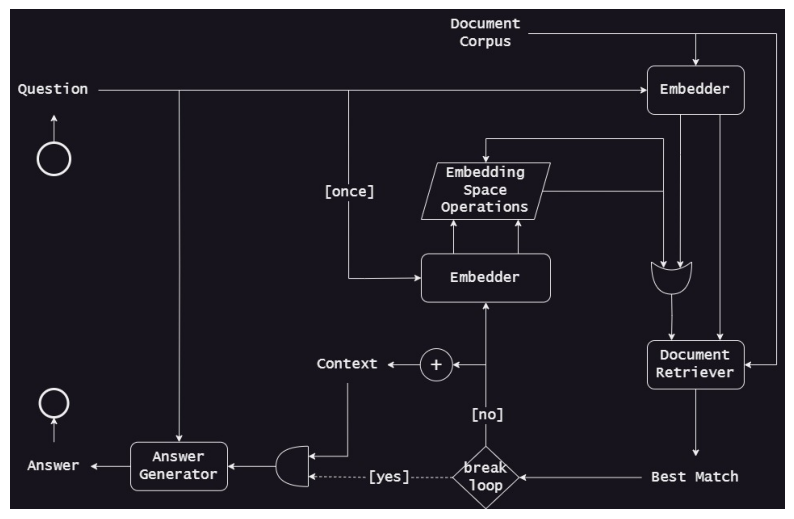

In [ ]:
image_path = '/content/drive/MyDrive/proj-nlp-2024/doc/iterative_similarity.jpg'
img = mpimg.imread(image_path)
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Doing operations in the embedding space to assess the exhaustion of the information requested in the question by the retrieved paragraph

In [ ]:
row = 88
question = df_hotpotqa['question'].iloc[row]
print(f"Question: \"{question}\"")
print("---------------------------------------")

missing_info_weight = 2
elbow_threshold = 0.1
context = ""
scores = []
first_time = True

question_embedding = semb_model.encode(question, convert_to_tensor=True)
num_iterations = 10
# Loop for the specified number of iterations
for iteration in range(num_iterations):
  # Search documents similar to question in index
  passage_id, distance = index.knn_query(question_embedding.cpu())

  # Calculate the similarity score
  score = 1 - distance[0][0]

  # Calculate the difference with the previous score
  difference = score - (scores[-1] if len(scores) > 1 else 0)

  # Save the iteration number where the actual function would have stopped
  if abs(difference) < elbow_threshold:
    if first_time:
      stopping_it = iteration
      first_time = False

  # Saving the similarity score of the currently retrieved paragraph
  scores.append(score)

  # Retrieve the most relevant passage in natural language
  passage = corpus[passage_id[0][0]]
  # Print the passage
  print(f"Iteration {iteration + 1}")
  print(f"Score: {score:.4f}\nDocument: \"{passage}\"\n")

  # Update the context
  context = passage + "\n" + context
  # Embed the retrieved passage
  passage_embedding = semb_model.encode(passage, convert_to_tensor=True)
  # Update the question in embedding space such that it gives more weight to the
  # information not addressed by the retrieved passage
  question_embedding = question_embedding + missing_info_weight * (question_embedding - passage_embedding)

  # # The formula is the result of the following equation system
  # missing_information = question_embedding - passage_embedding
  # question_embedding = question_embedding + missing_info_weight * missing_information

# Prompting the generative model to create an answer out of the retrieved passages
input_text = f"Given the following passages, answer the related question as concisely as possible.\n\nPassage:\n\n{context}\n\nQ: {question}"
answer = answer_generation(input_text, tokenizer=tokenizer_t5, generative_model=model_t5)
# answer = chatbot(input_text)
correct = df_hotpotqa['answers'].iloc[row]
print("---------------------------------------")
print(f"Predicted answer: \"{answer}\"")
print(f"Expected answer: \"{correct}\"")

Question: "Metrodorus of Chios, was a Greek philosopher, belonging to the school of Democritus, and an important forerunner of Epicurus, an ancient Greek philosopher who founded the school of philosophy called what?"
---------------------------------------
Iteration 1
Score: 0.9102
Document: "Metrodorus of Chios (Greek: ; fl. 4th century BC) was a Greek philosopher, belonging to the school of Democritus, and an important forerunner of Pyrrhonism and Epicureanism."

Iteration 2
Score: 0.5489
Document: "Epicurus ( ; 341–270 BC) was an ancient Greek philosopher and sage who founded Epicureanism, a highly influential school of philosophy. He was born on the Greek island of Samos to Athenian parents. Influenced by Democritus, Aristippus, Pyrrho, and possibly the Cynics, he turned against the Platonism of his day and established his own school, known as "the Garden", in Athens. Epicurus and his followers were known for eating simple meals and discussing a wide range of philosophical subjects

Token indices sequence length is longer than the specified maximum sequence length for this model (1236 > 512). Running this sequence through the model will result in indexing errors


Iteration 9
Score: 0.2313
Document: "Metrodorus of Chios (Greek: ; fl. 4th century BC) was a Greek philosopher, belonging to the school of Democritus, and an important forerunner of Pyrrhonism and Epicureanism."

Iteration 10
Score: 0.2310
Document: "Metrodorus of Chios (Greek: ; fl. 4th century BC) was a Greek philosopher, belonging to the school of Democritus, and an important forerunner of Pyrrhonism and Epicureanism."

---------------------------------------
Predicted answer: "Epicureanism"
Expected answer: "Epicureanism"


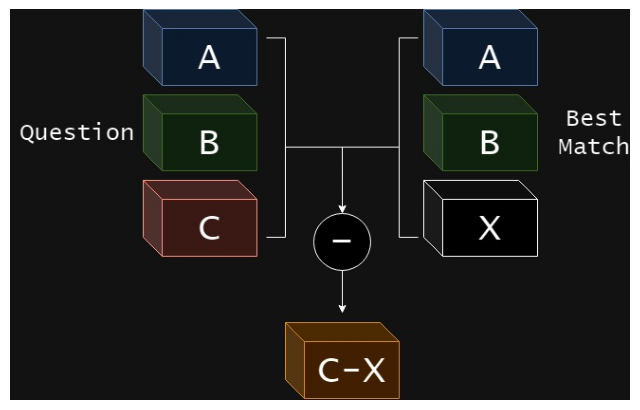

In [ ]:
image_path = '/content/drive/MyDrive/proj-nlp-2024/doc/semantic_elements.jpg'
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Evaluate how comprehensively the paragraph addresses the information asked in the question

Identify any content in the paragraph that is irrelevant to the question. This serves a dual purpose: highlighting what is missing in the passage (C) and penalizing the inclusion of unrelated information in the best-matching passage (X)

This method relies on the reasonable that there always exists an intersection between the at least two semantic elements of the query and the retrieved paragraph, those are necessary to link one hop to the next

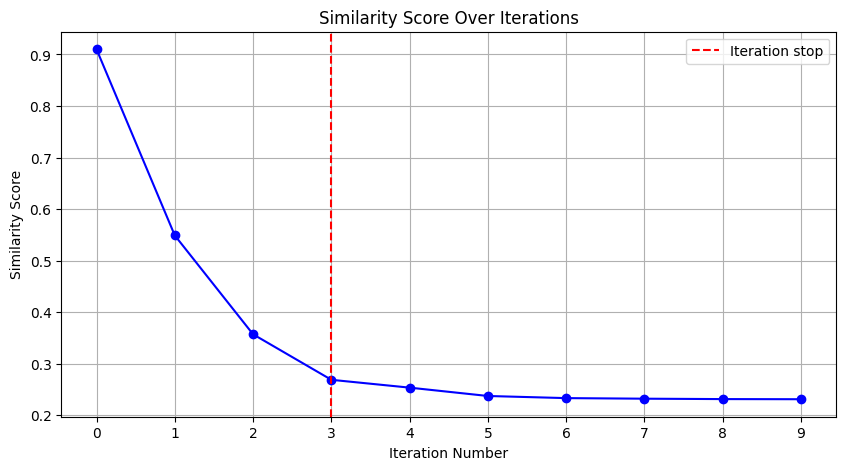

In [ ]:
import matplotlib.pyplot as plt
iterations = len(scores)
# Plotting the scores over iterations
plt.figure(figsize=(10, 5))
plt.plot(range(iterations), scores, marker='o', linestyle='-', color='b')
plt.title('Similarity Score Over Iterations')
plt.xticks(range(0, iterations))
plt.xlabel('Iteration Number')
plt.ylabel('Similarity Score')
plt.axvline(x=stopping_it, color='r', linestyle='--', label='Iteration stop')
plt.grid(True)
plt.legend()
plt.show()

## Hyperparameter Analysis

We need to determine the optimal values for the following hyperparameters:


*   missing_info_weight: The importance assigned to the unanswered aspects of the question versus what has already been established
*   elbow_threshold: The score threshold at which the relevance of the retrieved passage to the question diminishes to the point of not being useful



### Missing Information Weight

Defining a function to return similarity scores for the top retrieved document across multiple iterations

In [ ]:
def variable_hop_scores(
  question,
  missing_info_weight = 2,
  similarity_model=semb_model
):
  context = ""
  scores = []
  question_embedding = similarity_model.encode(question, convert_to_tensor=True)
  while not scores or scores[-1] >= 0.2:
    passage_id, distance = index.knn_query(question_embedding.cpu())
    score = 1 - distance[0][0]
    scores.append(score)
    passage = corpus[passage_id[0][0]]
    context = passage + "\n" + context
    passage_embedding = similarity_model.encode(passage, convert_to_tensor=True)
    question_embedding = question_embedding + missing_info_weight * (question_embedding - passage_embedding)

  return scores

Calculating similarity scores for the most relevant retrieved passages for 100 random questions across both datasets

In [ ]:
n = 100
results_hotpotqa = df_hotpotqa['question'].sample(n=n, random_state=seed).apply(variable_hop_scores).tolist()
results_squad = df_squad['question'].sample(n=n, random_state=seed).apply(variable_hop_scores).tolist()

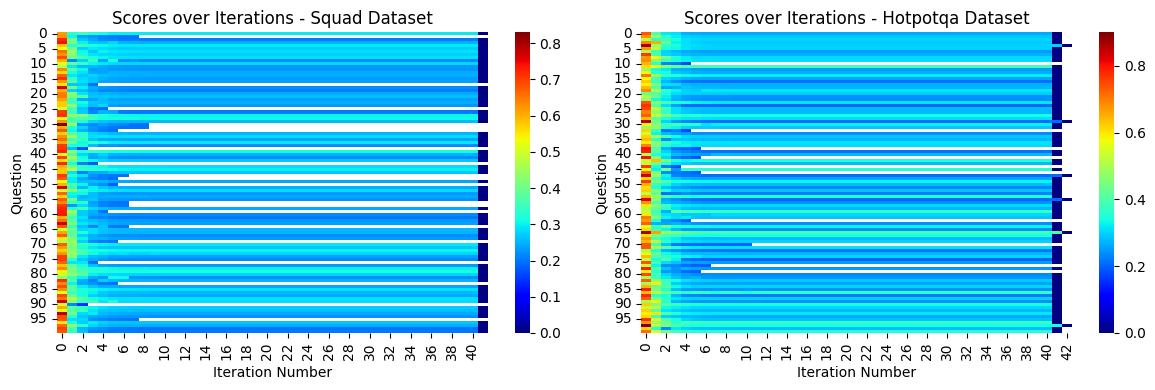

In [ ]:
import seaborn as sns
# Find the length of the longest list
max_len_hotpotqa = max(len(lst) for lst in results_hotpotqa)
max_len_squad = max(len(lst) for lst in results_squad)

# Pad shorter lists with NaNs
padded_results_hotpotqa = np.array([lst + [np.nan]*(max_len_hotpotqa - len(lst)) for lst in results_hotpotqa])
padded_results_squad = np.array([lst + [np.nan]*(max_len_squad - len(lst)) for lst in results_squad])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the second heatmap for squad
sns.heatmap(padded_results_squad, cmap='jet', ax=ax1)
ax1.set_title('Scores over Iterations - Squad Dataset')
ax1.set_xlabel('Iteration Number')
ax1.set_ylabel('Question')

# Plot the first heatmap for hotpotqa
sns.heatmap(padded_results_hotpotqa, cmap='jet', ax=ax2)
ax2.set_title('Scores over Iterations - Hotpotqa Dataset')
ax2.set_xlabel('Iteration Number')
ax2.set_ylabel('Question')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

We observe that questions in the SQuAD dataset (designed to assess single-hop performance) are resolved with fewer documents compared to those in HotpotQA (designed for double-hop performance)

 We also find that the number of semantically relevant documents the model can retrieve, when the weight given to the missing information is set to 2, plateaus around 41 for all documents, likely due to the limited corpus

Analyzing the trend with respect to different weights assigned to missing information

In [ ]:
results_hotpotqa_4 = df_hotpotqa['question'].sample(n=n, random_state=seed).apply(lambda x: variable_hop_scores(x, missing_info_weight=4)).tolist()
results_squad_4 = df_squad['question'].sample(n=n, random_state=seed).apply(lambda x: variable_hop_scores(x, missing_info_weight=4)).tolist()
results_hotpotqa_10 = df_hotpotqa['question'].sample(n=n, random_state=seed).apply(lambda x: variable_hop_scores(x, missing_info_weight=10)).tolist()
results_squad_10 = df_squad['question'].sample(n=n, random_state=seed).apply(lambda x: variable_hop_scores(x, missing_info_weight=10)).tolist()

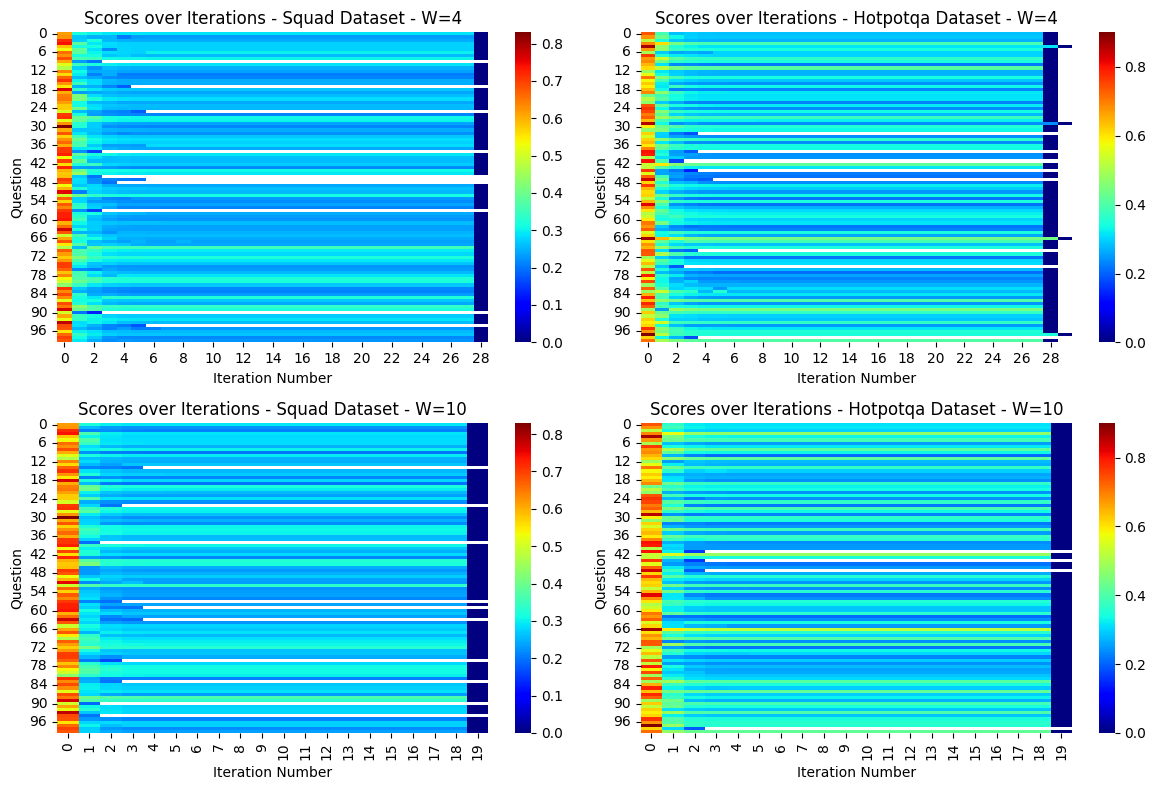

In [ ]:
# Find the length of the longest list
max_len_hotpotqa_4 = max(len(lst) for lst in results_hotpotqa_4)
max_len_squad_4 = max(len(lst) for lst in results_squad_4)
max_len_hotpotqa_10 = max(len(lst) for lst in results_hotpotqa_10)
max_len_squad_10 = max(len(lst) for lst in results_squad_10)

# Pad shorter lists with NaNs
padded_results_hotpotqa_4 = np.array([lst + [np.nan]*(max_len_hotpotqa_4 - len(lst)) for lst in results_hotpotqa_4])
padded_results_squad_4 = np.array([lst + [np.nan]*(max_len_squad_4 - len(lst)) for lst in results_squad_4])
padded_results_hotpotqa_10 = np.array([lst + [np.nan]*(max_len_hotpotqa_10 - len(lst)) for lst in results_hotpotqa_10])
padded_results_squad_10 = np.array([lst + [np.nan]*(max_len_squad_10 - len(lst)) for lst in results_squad_10])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
(ax1, ax2), (ax3, ax4) = axes

# Plot the second heatmap for squad with missing information weigth 4
sns.heatmap(padded_results_squad_4, cmap='jet', ax=ax1)
ax1.set_title('Scores over Iterations - Squad Dataset - W=4')
ax1.set_xlabel('Iteration Number')
ax1.set_ylabel('Question')

# Plot the first heatmap for hotpotqa with missing information weigth 4
sns.heatmap(padded_results_hotpotqa_4, cmap='jet', ax=ax2)
ax2.set_title('Scores over Iterations - Hotpotqa Dataset - W=4')
ax2.set_xlabel('Iteration Number')
ax2.set_ylabel('Question')

# Plot the first heatmap for squad with missing information weigth 10
sns.heatmap(padded_results_squad_10, cmap='jet', ax=ax3)
ax3.set_title('Scores over Iterations - Squad Dataset - W=10')
ax3.set_xlabel('Iteration Number')
ax3.set_ylabel('Question')

# Plot the first heatmap for hotpotqa with missing information weigth 10
sns.heatmap(padded_results_hotpotqa_10, cmap='jet', ax=ax4)
ax4.set_title('Scores over Iterations - Hotpotqa Dataset - W=10')
ax4.set_xlabel('Iteration Number')
ax4.set_ylabel('Question')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

We notice that assigning more weight to the embedding of missing information results in:


1.   The similarity threshold being reached more quickly
2.   An overall increase in the similarity scores of retrieved documents, as the new question embedding places more emphasis on information present in the passage but missing from the query



We choose to implement the model with weight = 2

### Similarity Score Elbow

Analyzing the trends in similarity scores of retrieved documents in the SQuAD dataset

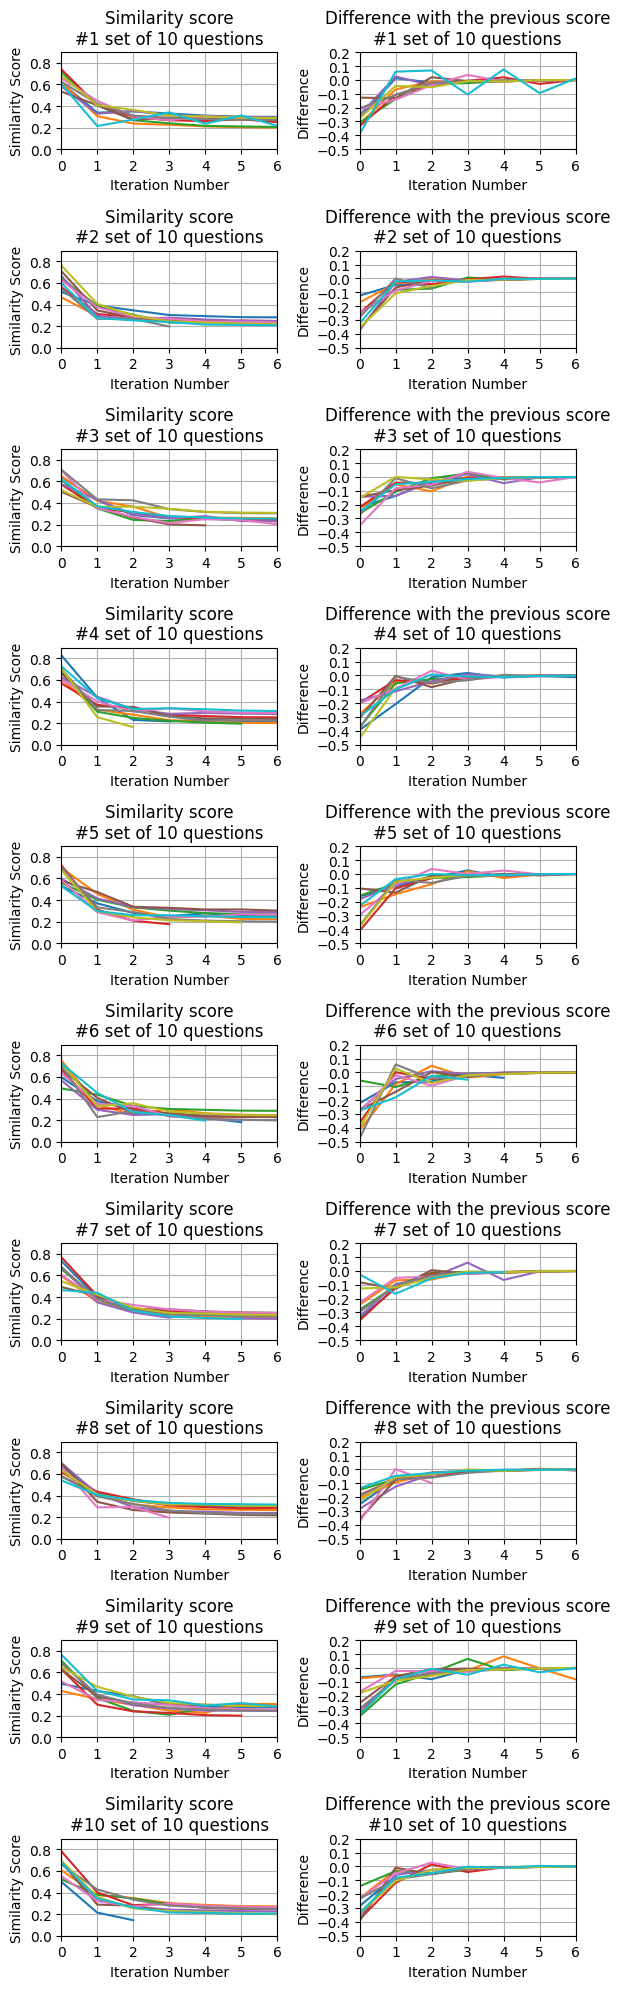

In [ ]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6, 20))
gs = fig.add_gridspec(10, 2, width_ratios=[1, 1])

# Plot the first 10 plots on the left
for i in range(10):
    ax = fig.add_subplot(gs[i, 0])
    for j in range(10):
        if 10*i + j < len(results_squad):
            ax.plot(results_squad[10*i + j], label=f'List {10*i + j + 1}')
    ax.set_title(f'Similarity score\n#{i+1} set of 10 questions')
    ax.set_xlabel('Iteration Number')
    ax.set_ylabel('Similarity Score')
    ax.set_xlim([0, 6])  # Limit x-axis
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_ylim([0, 0.9])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.grid(True)

# Plot the second 10 plots on the right
for i in range(10):
    ax = fig.add_subplot(gs[i, 1])
    for j in range(10):
        if 10*i + j < len(results_squad):
            differences = np.diff(results_squad[10*i + j])  # Calculate differences
            ax.plot(differences, label=f'List {10*i + j + 1}')
    ax.set_title(f'Difference with the previous score\n#{i+1} set of 10 questions')
    ax.set_xlabel('Iteration Number')
    ax.set_ylabel('Difference')
    ax.set_xlim([0, 6])  # Limit x-axis to 6
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_ylim([-0.5, 0.2])  # Adjust y-axis limits
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Increase number of y-axis ticks
    plt.grid(True)

plt.tight_layout()
plt.show()

Analyzing the trends in similarity scores of retrieved documents in the HotpotQA dataset

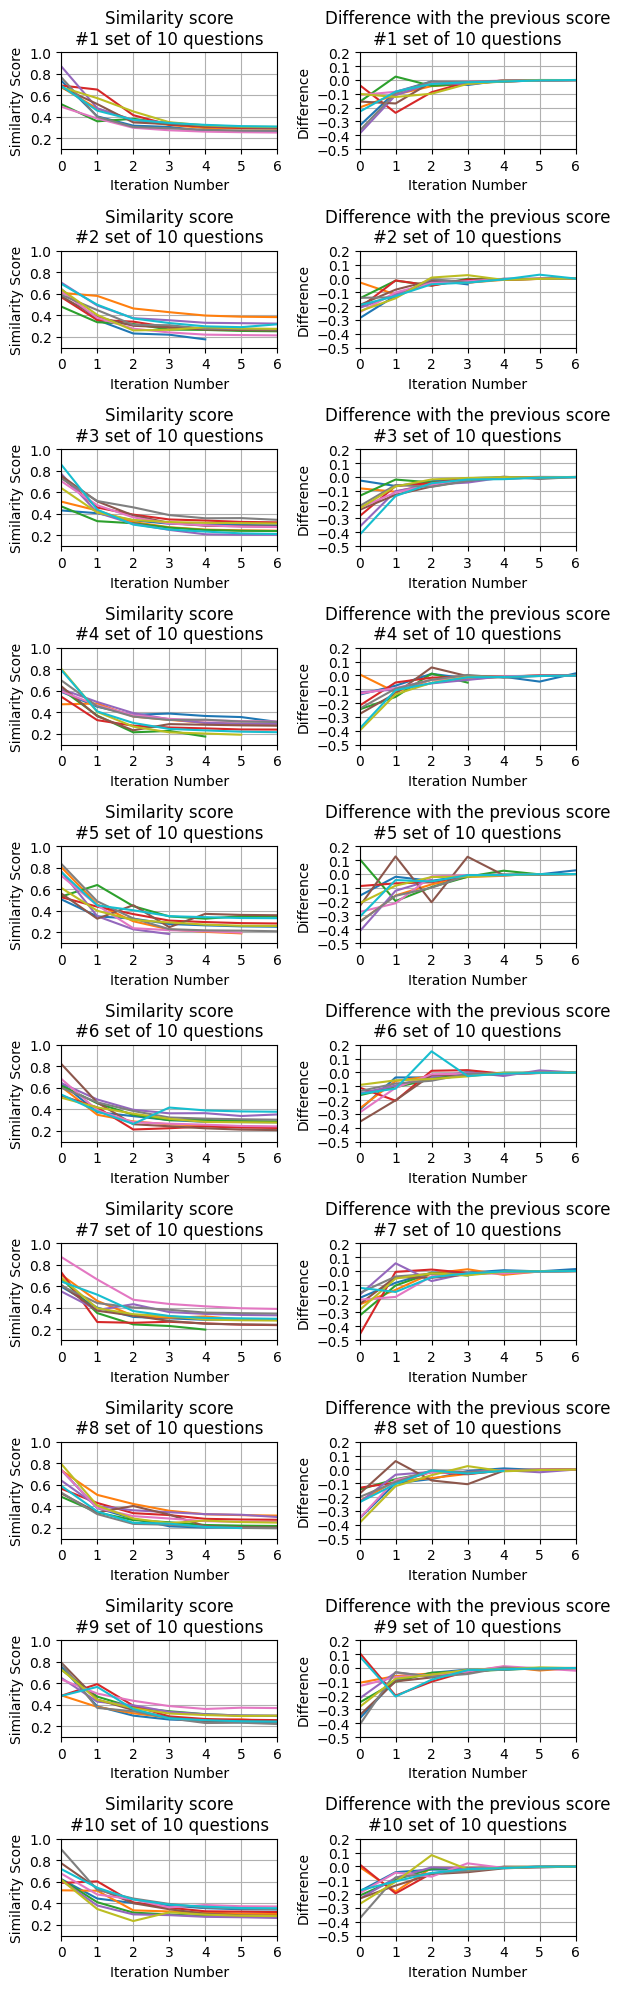

In [ ]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6, 20))
gs = fig.add_gridspec(10, 2, width_ratios=[1, 1])

# Plot the first 10 plots on the left
for i in range(10):
    ax = fig.add_subplot(gs[i, 0])
    for j in range(10):
        if 10*i + j < len(results_hotpotqa):
            ax.plot(results_hotpotqa[10*i + j], label=f'List {10*i + j + 1}')
    ax.set_title(f'Similarity score\n#{i+1} set of 10 questions')
    ax.set_xlabel('Iteration Number')
    ax.set_ylabel('Similarity Score')
    ax.set_xlim([0, 6])  # Limit x-axis
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_ylim([0.1, 1])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.grid(True)

# Plot the second 10 plots on the right
for i in range(10):
    ax = fig.add_subplot(gs[i, 1])
    for j in range(10):
        if 10*i + j < len(results_hotpotqa):
            differences = np.diff(results_hotpotqa[10*i + j])  # Calculate differences
            ax.plot(differences, label=f'List {10*i + j + 1}')
    ax.set_title(f'Difference with the previous score\n#{i+1} set of 10 questions')
    ax.set_xlabel('Iteration Number')
    ax.set_ylabel('Difference')
    ax.set_xlim([0, 6])  # Limit x-axis to 6
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_ylim([-0.5, 0.2])  # Adjust y-axis limits
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Increase number of y-axis ticks
    plt.grid(True)

plt.tight_layout()
plt.show()

To identify the score elbow, we use a threshold of 0.1. If the absolute difference in similarity scores between the current and previous iterations is less than 0.1, the iteration stops

Additionally, it is generally ineffective to exceed 6 iterations, so we set 6 as the maximum number of iterations

## Evaluating Different Implementations

### Simple Iterative Similarity

In [ ]:
def pipeline_sis(
  question,
  missing_info_weight=2,
  elbow_threshold=0.1,
  max_iter=6,
  corpus=corpus,
  similarity_model=semb_model,
  embeddings_index=index,
  tokenizer=tokenizer_t5,
  generative_model=model_t5,
  device=device
):
  context = ""
  scores = []
  question_embedding = similarity_model.encode(question, convert_to_tensor=True)
  for it in range(max_iter):
    passage_id, distance = embeddings_index.knn_query(question_embedding.cpu())
    score = 1 - distance[0][0]
    difference = score - (scores[-1] if len(scores) > 1 else 0)
    # Break if the difference is below the threshold
    if abs(difference) < elbow_threshold:
      break
    scores.append(score)
    passage = corpus[passage_id[0][0]]
    context = passage + "\n" + context
    passage_embedding = similarity_model.encode(passage, convert_to_tensor=True)
    question_embedding = question_embedding + missing_info_weight * (question_embedding - passage_embedding)

  input_text = f"Given the following passages, answer the related question as concisely as possible.\n\nPassage:\n\n{context}\n\nQ: {question}"
  answer = answer_generation(input_text, tokenizer=tokenizer, generative_model=generative_model)
  return answer

In [ ]:
row = 88
question = df_hotpotqa['question'].iloc[row]
answer = pipeline_sis(question)
correct = df_hotpotqa['answers'].iloc[row]
print(f"Question: {question}\n\nPredicted answer: {answer}\n\nCorrect answer: {correct}")

Question: Metrodorus of Chios, was a Greek philosopher, belonging to the school of Democritus, and an important forerunner of Epicurus, an ancient Greek philosopher who founded the school of philosophy called what?

Predicted answer: Epicureanism

Correct answer: Epicureanism


Evaluating

In [ ]:
# SQuAD
path = f'{data_path}/squad_predictions_sis.csv'
df_squad_sis = run_predictions(df_squad, path, pipeline_sis)
print("---------------------------------------------------------------")
print('SQuAD SIS')
score_predictions(df_squad_sis)

# HotpotQA
path = f'{data_path}/hotpotqa_predictions_sis.csv'
df_hotpotqa_sis = run_predictions(df_hotpotqa, path, pipeline_sis)
print("---------------------------------------------------------------")
print('HotpotQA SIS')
score_predictions(df_hotpotqa_sis)

---------------------------------------------------------------
SQuAD SIS
F1: 0.5331558364403949
EM: 0.418
---------------------------------------------------------------
HotpotQA SIS
F1: 0.3912974874798404
EM: 0.328


### Iterative Similarity with Cross-Encoding

In [ ]:
def pipeline_isce(
  question,
  missing_info_weight=2,
  elbow_threshold=0.1,
  max_iter=6,
  corpus=corpus,
  similarity_model=semb_model,
  embeddings_index=index,
  re_ranking_model=xenc_model,
  tokenizer=tokenizer_t5,
  generative_model=model_t5,
  device=device
):
  context = ""
  scores = []
  # Retrieving the first most relevant document through cross-encoding
  question_embedding = similarity_model.encode(question, convert_to_tensor=True)
  corpus_ids, distances = embeddings_index.knn_query(question_embedding.cpu(), k=128)
  re_ranker_inputs = [(question, corpus[idx]) for idx in corpus_ids[0]]
  cross_scores = re_ranking_model.predict(re_ranker_inputs)
  passage_idx = np.argsort(-cross_scores)[0]
  # Saving the passage in natural language and its similarity score
  passage = corpus[corpus_ids[0][passage_idx]]
  context = passage + "\n" + context
  scores.append(cross_scores[passage_idx])
  # Updating the embedding of the question
  passage_embedding = similarity_model.encode(passage, convert_to_tensor=True)
  question_embedding = question_embedding + missing_info_weight * (question_embedding - passage_embedding)
  for it in range(max_iter):
    passage_id, distance = embeddings_index.knn_query(question_embedding.cpu())
    score = 1 - distance[0][0]
    difference = score - (scores[-1] if len(scores) > 1 else 0)
    if abs(difference) < elbow_threshold:
      break
    scores.append(score)
    passage = corpus[passage_id[0][0]]
    context = passage + "\n" + context
    passage_embedding = similarity_model.encode(passage, convert_to_tensor=True)
    question_embedding = question_embedding + missing_info_weight * (question_embedding - passage_embedding)

  input_text = f"Given the following passages, answer the related question as concisely as possible.\n\nPassage:\n\n{context}\n\nQ: {question}"
  answer = answer_generation(input_text, tokenizer=tokenizer, generative_model=generative_model)
  return answer

In [ ]:
# SQuAD
path = f'{data_path}/squad_predictions_isce.csv'
df_squad_isce = run_predictions(df_squad, path, pipeline_isce)
print("---------------------------------------------------------------")
print('SQuAD ISCE')
score_predictions(df_squad_isce)

# HotpotQA
path = f'{data_path}/hotpotqa_predictions_isce.csv'
df_hotpotqa_isce = run_predictions(df_hotpotqa, path, pipeline_isce)
print("---------------------------------------------------------------")
print('HotpotQA ISCE')
score_predictions(df_hotpotqa_isce)

---------------------------------------------------------------
SQuAD ISCE
F1: 0.7227397115845756
EM: 0.586
---------------------------------------------------------------
HotpotQA ISCE
F1: 0.48145502079619723
EM: 0.408


### ISCE with Missing Information Only

In [ ]:
def pipeline_mio(
  question,
  missing_info_weight=2,
  elbow_threshold=0.1,
  max_iter=6,
  corpus=corpus,
  similarity_model=semb_model,
  embeddings_index=index,
  re_ranking_model=xenc_model,
  tokenizer=tokenizer_t5,
  generative_model=model_t5,
  device=device
):
  context = ""
  scores = []
  question_embedding = similarity_model.encode(question, convert_to_tensor=True)
  corpus_ids, distances = embeddings_index.knn_query(question_embedding.cpu(), k=128)
  re_ranker_inputs = [(question, corpus[idx]) for idx in corpus_ids[0]]
  cross_scores = re_ranking_model.predict(re_ranker_inputs)
  passage_idx = np.argsort(-cross_scores)[0]
  passage = corpus[corpus_ids[0][passage_idx]]
  context = passage + "\n" + context
  scores.append(cross_scores[passage_idx])
  passage_embedding = similarity_model.encode(passage, convert_to_tensor=True)
  question_embedding = question_embedding - passage_embedding
  for it in range(max_iter):
    passage_id, distance = embeddings_index.knn_query(question_embedding.cpu())
    score = 1 - distance[0][0]
    difference = score - (scores[-1] if len(scores) > 1 else 0)
    if abs(difference) < elbow_threshold:
      break
    scores.append(score)
    passage = corpus[passage_id[0][0]]
    context = passage + "\n" + context
    passage_embedding = similarity_model.encode(passage, convert_to_tensor=True)
    # Removing completely the exhausted information from the quesion embedding
    question_embedding = question_embedding - passage_embedding

  input_text = f"Given the following passages, answer the related question as concisely as possible.\n\nPassage:\n\n{context}\n\nQ: {question}"
  answer = answer_generation(input_text, tokenizer=tokenizer, generative_model=generative_model)
  return answer

In [ ]:
# SQuAD
path = f'{data_path}/squad_predictions_mio.csv'
df_squad_mio = run_predictions(df_squad, path, pipeline_mio)
print("---------------------------------------------------------------")
print('SQuAD MIO')
score_predictions(df_squad_mio)

# HotpotQA
path = f'{data_path}/hotpotqa_predictions_mio.csv'
df_hotpotqa_mio = run_predictions(df_hotpotqa, path, pipeline_mio)
print("---------------------------------------------------------------")
print('HotpotQA MIO')
score_predictions(df_hotpotqa_mio)

---------------------------------------------------------------
SQuAD MIO
F1: 0.7189271811730593
EM: 0.584
---------------------------------------------------------------
HotpotQA MIO
F1: 0.4524742090382957
EM: 0.38


### Comparison

Given the best model, we analyze its performance with changing parameters.

In [ ]:
# SQuAD
path = f'{data_path}/squad_predictions_isce_w3_t01.csv'
if os.path.exists(path):
    df_squad_isce = pd.read_csv(path).astype(str)
else:
  df_squad_isce = df_squad
  df_squad_isce.loc[:, 'predictions'] = df_squad_isce['question'].apply(lambda x: pipeline_isce(x, missing_info_weight=3)).astype(str)
  df_squad_isce.to_csv(path) # Saving the dataframe
print("---------------------------------------------------------------")
print('SQuAD ISCE - W=3 T=0.1')
score_predictions(df_squad_isce)

# HotpotQA
path = f'{data_path}/hotpotqa_predictions_isce_w3_t01.csv'
if os.path.exists(path):
    df_hotpotqa_isce = pd.read_csv(path).astype(str)
else:
  df_hotpotqa_isce = df_squad
  df_hotpotqa_isce.loc[:, 'predictions'] = df_hotpotqa_isce['question'].apply(lambda x: pipeline_isce(x, missing_info_weight=3)).astype(str)
  df_hotpotqa_isce.to_csv(path) # Saving the dataframe
print("---------------------------------------------------------------")
print('HotpotQA ISCE - W=3 T=0.1')
score_predictions(df_hotpotqa_isce)

---------------------------------------------------------------
SQuAD ISCE - W=3 T=0.1
F1: 0.7225851777403864
EM: 0.586
---------------------------------------------------------------
HotpotQA ISCE - W=3 T=0.1
F1: 0.4716416008827773
EM: 0.402


In [ ]:
# SQuAD
path = f'{data_path}/squad_predictions_isce_w3_t005.csv'
if os.path.exists(path):
    df_squad_isce = pd.read_csv(path).astype(str)
else:
  df_squad_isce = df_squad
  df_squad_isce.loc[:, 'predictions'] = df_squad_isce['question'].apply(lambda x: pipeline_isce(x, missing_info_weight=3, elbow_threshold=0.05)).astype(str)
  df_squad_isce.to_csv(path) # Saving the dataframe
print("---------------------------------------------------------------")
print('SQuAD ISCE - W=3 T=0.05')
score_predictions(df_squad_isce)

# HotpotQA
path = f'{data_path}/hotpotqa_predictions_isce_w3_t005.csv'
if os.path.exists(path):
    df_hotpotqa_isce = pd.read_csv(path).astype(str)
else:
  df_hotpotqa_isce = df_squad
  df_hotpotqa_isce.loc[:, 'predictions'] = df_hotpotqa_isce['question'].apply(lambda x: pipeline_isce(x, missing_info_weight=3, elbow_threshold=0.05)).astype(str)
  df_hotpotqa_isce.to_csv(path) # Saving the dataframe
print("---------------------------------------------------------------")
print('HotpotQA ISCE - W=3 T=0.05')
score_predictions(df_hotpotqa_isce)

---------------------------------------------------------------
SQuAD ISCE - W=3 T=0.05
F1: 0.7145180290821734
EM: 0.574
---------------------------------------------------------------
HotpotQA ISCE - W=3 T=0.05
F1: 0.4779385705797471
EM: 0.408


We notice that the best performing model is the one that stops the iteration sooner.

Our findings are in line with the ones reported in the reference paper: performance on SQuAD questions is better when less weight is given to missing information.

# STT-TTS

In [ ]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=765b6865be8aae02019df02c211ddb6aba2d8fb4f35b2a7ee75f23569e6bdd05
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from scipy.io.wavfile import write as wav_write
import torch.nn.utils.rnn as rnn_utils
import ffmpeg
import io
from base64 import b64decode
from IPython.display import display, HTML, Audio
from google.colab.output import eval_js
import numpy as np
from scipy.io.wavfile import read as wav_read

In [ ]:
#Load Whisper model
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to("cuda" if torch.cuda.is_available() else "cpu")

#Initialize Tacotron2 and WaveGlow models
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

#Load the necessary utilities for NVIDIA's Tacotron2 TTS model
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:

def audio_prompt():
    AUDIO_HTML = """
    <script>
    var my_div = document.createElement("DIV");
    var my_p = document.createElement("P");
    var my_btn = document.createElement("BUTTON");
    var t = document.createTextNode("Press to start recording");

    my_btn.appendChild(t);
    my_div.appendChild(my_btn);
    document.body.appendChild(my_div);

    var base64data = 0;
    var reader;
    var recorder, gumStream;
    var recordButton = my_btn;

    var handleSuccess = function(stream) {
        gumStream = stream;
        recorder = new MediaRecorder(stream);
        recorder.ondataavailable = function(e) {
            var url = URL.createObjectURL(e.data);
            var preview = document.createElement('audio');
            preview.controls = true;
            preview.src = url;
            document.body.appendChild(preview);

            reader = new FileReader();
            reader.readAsDataURL(e.data);
            reader.onloadend = function() {
                base64data = reader.result;
            }
        };
        recorder.start();
    };

    recordButton.innerText = "Recording... press to stop";

    navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);

    function toggleRecording() {
        if (recorder && recorder.state == "recording") {
            recorder.stop();
            gumStream.getAudioTracks()[0].stop();
            recordButton.innerText = "Saving the recording... pls wait!"
        }
    }

    function sleep(ms) {
        return new Promise(resolve => setTimeout(resolve, ms));
    }

    var data = new Promise(resolve=>{
        recordButton.onclick = ()=>{
            toggleRecording()
            sleep(2000).then(() => {
                resolve(base64data.toString())
            });
        }
    });
    </script>
    """

    def get_audio():
        display(HTML(AUDIO_HTML))
        data = eval_js("data")
        binary = b64decode(data.split(',')[1])

        process = (ffmpeg
            .input('pipe:0')
            .output('pipe:1', format='wav')
            .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
        )
        output, err = process.communicate(input=binary)

        riff_chunk_size = len(output) - 8
        q = riff_chunk_size
        b = []
        for i in range(4):
            q, r = divmod(q, 256)
            b.append(r)

        riff = output[:4] + bytes(b) + output[8:]

        sr, audio = wav_read(io.BytesIO(riff))

        return audio, sr

    #Load Whisper model
    trascription_model = whisper.load_model("base").to(device)
    #Initialize Tacotron2 and WaveGlow models
    tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
    tacotron2 = tacotron2.to('cuda')
    tacotron2.eval()
    waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
    waveglow = waveglow.remove_weightnorm(waveglow)
    waveglow = waveglow.to('cuda')
    waveglow.eval()

    #Load the necessary utilities for NVIDIA's Tacotron2 TTS model
    utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

    while True:
        #Record audio
        audio, sr = get_audio()
        #print(sr)
        #Save the audio to a file
        wavfile = "recorded_audio.wav"
        wav_write(wavfile, sr, audio)

        #Transcription using Whisper
        transcription = trascription_model.transcribe(wavfile)
        print("You:", transcription['text'])

        if "stop" in transcription['text'].lower():
            print("Detected 'stop' in the transcription. Stopping the loop.")
            break

        #Answer generation
        answer = pipeline_GPT(transcription['text'])
        print(f"GPT: {answer}")
        #Convert the answer text into sequences and calculates their lengths.
        sequences, lengths = utils.prepare_input_sequence([answer])

        #The Tacotron2 model to generate mel spectrograms.
        with torch.no_grad():
            mel, _, _ = tacotron2.infer(sequences, lengths)

        #Generate audio waveform from the mel spectrograms.
        with torch.no_grad():
            audio = waveglow.infer(mel)
            audio_numpy = audio[0].data.cpu().numpy()  # Convert the audio tensor to a numpy array
            rate = 22050  # Sample rate of the audio

        #Display the audio waveform using IPython.display.Audio
        display(Audio(audio_numpy, rate=rate))
        break

In [ ]:
audio_prompt()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


You:  Who is Michael Jackson?
GPT: singer
